In [ ]:
import os
import json
import random
import shutil

In [ ]:
def combine_json_with_velocity(data_dir, out_dir):
    # Helper function to sort file names numerically
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Get the list of JSON files (excluding velocity files)
    keypoint_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json') and not f.endswith('_vel.json') and not f.endswith('_combined.json') and not f.endswith('_joint_angles.json')])
    # Process each file (except the last one)
    for i in range(len(keypoint_files) - 1):
        current_file = keypoint_files[i]
        next_file = keypoint_files[i + 1]
#         velocity_file = next_file.replace('.json', '_vel.json')
        velocity_file = current_file.replace('.json', '_vel.json')

        joint_angles_file_1 = current_file.replace('.json', '_joint_angles.json')
        joint_angles_file_2 = next_file.replace('.json', '_joint_angles.json')

        # Read the current keypoints JSON file
        with open(os.path.join(data_dir, current_file), 'r') as file:
            current_data = json.load(file)
        start_kp = current_data['keypoints']

        # Read the next keypoints JSON file
        with open(os.path.join(data_dir, next_file), 'r') as file:
            next_data = json.load(file)
        next_kp = next_data['keypoints']

        # Read the corresponding velocity JSON file
        with open(os.path.join(data_dir, velocity_file), 'r') as file:
            velocity_data = json.load(file)
        velocity = velocity_data['velocity']
        # time = velocity_data['time_rate']
        time = 1/15
        
        position = [v * time for v in velocity]

        # Read the joint angles from the corresponding files
        with open(os.path.join(data_dir, joint_angles_file_1), 'r') as file:
            joint_angles_data_1 = json.load(file)
        with open(os.path.join(data_dir, joint_angles_file_2), 'r') as file:
            joint_angles_data_2 = json.load(file)

        # Extract the joint angles lists
        joint_angles_1 = joint_angles_data_1['joint_angles']
        joint_angles_2 = joint_angles_data_2['joint_angles']

        # Calculate actual joint displacement
        joint_displacement = [j2 - j1 for j1, j2 in zip(joint_angles_1, joint_angles_2)]


        # Combine the data
        combined_data = {
            "start_kp": start_kp,
            "next_kp": next_kp,
            "position": position,
            "actual_joint_displacement": joint_displacement
        }

        # Save the combined data to a new JSON file
        combined_filename = current_file.replace('.json', '_combined.json')
        with open(os.path.join(out_dir, combined_filename), 'w') as outfile:
            json.dump(combined_data, outfile, indent=4)

        print(f"Combined data saved in {combined_filename}")

In [ ]:
directory = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/20_kp_cleaned/'
out_dir = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/20_uncomb_out/'

In [ ]:
combine_json_with_velocity(directory, out_dir)

In [ ]:
def corrected_combine_json_files(folder_path, combination_intervals, joint_angles_dir):
    # Get a list of all JSON files in the folder, sorted by file number
    json_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith("_combined.json")],
        key=lambda x: int(x.split('_')[0])
    )

    # Initialize the file index for new combined files
    last_file_index = int(json_files[-1].split('_')[0])
    
    # Iterate over starting indices and combination intervals
    for start_index in range(len(json_files)):
        for interval in combination_intervals:
            # Ensure the combination does not exceed the number of files
            if start_index + interval > len(json_files):
                continue            box_

            # Files to combine starting from the current index with the current interval
            files_to_combine = json_files[start_index:start_index + interval]

            print("files to combine", files_to_combine)

            # Initialize combined data structure
            combined_data = {
                "start_kp": None,
                "next_kp": None,
                "position": [0.0, 0.0, 0.0],  # Start with zeros for summing positions
                "actual_joint_displacement": None 
            }

            for index, file_name in enumerate(files_to_combine):
                file_path = os.path.join(folder_path, file_name)

                # Load JSON data from file
                with open(file_path, 'r') as file:
                    data = json.load(file)

                # Set start_kp from the first file and next_kp from the last file
                if index == 0:
                    combined_data["start_kp"] = data["start_kp"]
                if index == len(files_to_combine) - 1:
                    combined_data["next_kp"] = data["next_kp"]

                # Sum the position values
                combined_data["position"] = [sum(x) for x in zip(combined_data["position"], data["position"])]

            # Load joint angles to calculate the actual joint displacement
            first_joint_angles_file = f"{files_to_combine[0].split('_')[0]}_joint_angles.json"
            last_joint_angles_file = f"{files_to_combine[-1].split('_')[0]}_joint_angles.json"
            first_joint_angles_path = os.path.join(joint_angles_dir, first_joint_angles_file)
            last_joint_angles_path = os.path.join(joint_angles_dir, last_joint_angles_file)

            print(os.path.exists(last_joint_angles_path))

            if not os.path.exists(last_joint_angles_path):
                last_joint_angles_file = f"{files_to_combine[-2].split('_')[0]}_joint_angles.json"
                last_joint_angles_path = os.path.join(joint_angles_dir, last_joint_angles_file)

            print(first_joint_angles_file)
            print(last_joint_angles_file)

            # Read the joint angles from the first and last files
            with open(first_joint_angles_path, 'r') as file:
                joint_angles_data_1 = json.load(file)
            with open(last_joint_angles_path, 'r') as file:
                joint_angles_data_2 = json.load(file)

            # Extract the joint angles lists
            joint_angles_1 = joint_angles_data_1['joint_angles']
            joint_angles_2 = joint_angles_data_2['joint_angles']

            # Calculate the actual joint displacement
            joint_displacement = [j2 - j1 for j1, j2 in zip(joint_angles_1, joint_angles_2)]

            # Set the calculated actual joint displacement in the combined data
            combined_data["actual_joint_displacement"] = joint_displacement

            # Update the file index for new file name
            last_file_index += 1
            new_file_name = f"{last_file_index:06}_combined.json"
            new_file_path = os.path.join(folder_path, new_file_name)

            # Write the combined data to a new JSON file
            with open(new_file_path, 'w') as new_file:
                json.dump(combined_data, new_file, indent=4)

            print(f"Created new combined file: {new_file_name} starting from index {start_index} with interval {interval}")

In [ ]:
def combine_and_renumber_folders(source_folders, dest_folder):
    """
    Combine and renumber JSON files from multiple source folders into a single destination folder,
    ensuring sequential numbering.
    
    Parameters:
    - source_folders: List of paths to the source folders.
    - dest_folder: Path to the destination folder.
    """
    # Ensure the destination folder exists
    
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    all_files = []
    # Collect all files from each source folder
    for folder in source_folders:
        folder_files = [os.path.join(folder, f) for f in sorted(os.listdir(folder)) if f.endswith('_combined.json')]
        all_files.extend(folder_files)
    
    # Renumber and copy files to the destination folder
    for i, file_path in enumerate(all_files, start=0):  # Start enumeration from 0
        new_file_name = f"{i:06d}_combined.json"
        new_file_path = os.path.join(dest_folder, new_file_name)
        
        shutil.copy(file_path, new_file_path)
        
        print(f"Copied {file_path} to {new_file_path}")


In [ ]:
source_folders = [
                    '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/1_uncomb_out/', 
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/2_uncomb_out/', 
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/3_uncomb_out/', 
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/4_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/5_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/6_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/7_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/8_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/9_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/10_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/11_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/12_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/13_uncomb_out/',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/14_uncomb_out',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/15_uncomb_out',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/16_uncomb_out',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/17_uncomb_out',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/18_uncomb_out',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/19_uncomb_out',
                      '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/20_uncomb_out']

In [ ]:
destination_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_uncombined/'
combine_and_renumber_folders(source_folders, destination_folder)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def compute_norm(vector):
    """Compute the norm (magnitude) of a vector."""
    return np.linalg.norm(vector)

def process_json_files(folder_path):
    position_norms = []
    joint_displacement_norms = []

    # Iterate through all JSON files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                
                # Extract position and actual_joint_displacement
                position = data['position']
                actual_joint_displacement = data['actual_joint_displacement']

                # Compute norms
                position_norm = compute_norm(position)
                joint_displacement_norm = compute_norm(actual_joint_displacement)

                # Store norms
                position_norms.append(position_norm)
                joint_displacement_norms.append(joint_displacement_norm)

    return position_norms, joint_displacement_norms

def plot_comparisons(position_norms, joint_displacement_norms):
    # Scatter Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(position_norms, joint_displacement_norms, alpha=0.7)
    plt.xlabel('Custom joint displacement')
    plt.ylabel('Actual joint displacement')
    plt.title('Comparison of Position Norm and Actual Joint Displacement Norm')
    plt.grid(True)
    # plt.show()

    # Histogram Plot for Position Norms
    plt.figure(figsize=(20, 10))
    plt.hist(position_norms, bins=20, alpha=0.7, label='Custom joint displacements')
    plt.hist(joint_displacement_norms, bins=20, alpha=0.7, label='Actual joint displacements')
    plt.xlabel('Norm Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Norms', fontsize=16)    
    plt.legend(fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.savefig('/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_vs_actual.png')
    plt.show()

    # Line Plot to observe trends
    plt.figure(figsize=(10, 5))
    plt.plot(position_norms, label='Position Norms', marker='o')
    plt.plot(joint_displacement_norms, label='Joint Displacement Norms', marker='x')
    plt.xlabel('File Index')
    plt.ylabel('Norm Value')
    plt.title('Trends of Norms Across JSON Files')
    plt.legend()
    plt.grid(True)
    # plt.show()



In [ ]:
# Example usage
folder_path = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_uncombined/'  # Replace with the path to your JSON files
position_norms, joint_displacement_norms = process_json_files(folder_path)
plot_comparisons(position_norms, joint_displacement_norms)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def process_json_files(folder_path):
    positions = []
    joint_displacements = []

    # Iterate through all JSON files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                
                # Extract position and actual_joint_displacement
                position = data['position']
                actual_joint_displacement = data['actual_joint_displacement']

                # Store positions and joint displacements
                positions.append(position)
                joint_displacements.append(actual_joint_displacement)

    return positions, joint_displacements

def plot_3d_comparison(positions, joint_displacements):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert lists to numpy arrays for easier indexing
    positions = np.array(positions)
    joint_displacements = np.array(joint_displacements)

    # Scatter plot for positions
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c='b', marker='o', label='Position')

    # Scatter plot for joint displacements
    ax.scatter(joint_displacements[:, 0], joint_displacements[:, 1], joint_displacements[:, 2], c='r', marker='^', label='Joint Displacement')

    # Adding labels
    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')
    ax.set_title('3D Comparison of Positions and Joint Displacements')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
    


In [ ]:
# Folder path to JSON files
folder_path = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_uncombined/'

# Process the JSON files
positions, joint_displacements = process_json_files(folder_path)

# Plot the comparison in 3D
plot_3d_comparison(positions, joint_displacements)

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def compute_norm(vector):
    """Compute the norm (magnitude) of a vector."""
    return np.linalg.norm(vector)

def process_json_files(folder_path):
    positions = []
    joint_displacements = []

    # Iterate through all JSON files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                
                # Extract position and actual_joint_displacement
                position = data['position']
                actual_joint_displacement = data['actual_joint_displacement']

                # Store values
                positions.append(position)
                joint_displacements.append(actual_joint_displacement)

    return np.array(positions), np.array(joint_displacements)

def plot_boxplots_with_external_table(positions, joint_displacements):
    # Separate the data into components
    joint1_approx = positions[:, 0]
    joint2_approx = positions[:, 1]
    joint3_approx = positions[:, 2]
    
    joint1_actual = joint_displacements[:, 0]
    joint2_actual = joint_displacements[:, 1]
    joint3_actual = joint_displacements[:, 2]

    # Create subplots for each joint
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Box Plot Comparison of Approximated and Actual Joint Displacements')

    # Data for plotting
    data_joint1 = [joint1_approx, joint1_actual]
    data_joint2 = [joint2_approx, joint2_actual]
    data_joint3 = [joint3_approx, joint3_actual]
    
    # Colors for the boxes
    colors = ['#FFFF00', '#FF00FF']  # Yellow for "Approximated", Magenta for "Actual"

    # Store statistics for the table
    stats = []

    # Plot Joint 1
    bp1 = axes[0].boxplot(data_joint1, patch_artist=True, vert=True, showfliers = False)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    # Calculate mean and std
    means_joint1 = [np.mean(joint1_approx), np.mean(joint1_actual)]
    stds_joint1 = [np.std(joint1_approx), np.std(joint1_actual)]
    stats.append([f'{means_joint1[0]:.8f}', f'{stds_joint1[0]:.8f}', f'{means_joint1[1]:.8f}', f'{stds_joint1[1]:.8f}'])
    
    axes[0].set_title('Joint 1 Comparison')
    axes[0].set_xticks([1, 2])
    axes[0].set_xticklabels(['Approximated', 'Actual'])
    axes[0].set_ylabel('Value')

    # Plot Joint 2
    bp2 = axes[1].boxplot(data_joint2, patch_artist=True)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
    # Calculate mean and std
    means_joint2 = [np.mean(joint2_approx), np.mean(joint2_actual)]
    stds_joint2 = [np.std(joint2_approx), np.std(joint2_actual)]
    stats.append([f'{means_joint2[0]:.8f}', f'{stds_joint2[0]:.8f}', f'{means_joint2[1]:.8f}', f'{stds_joint2[1]:.8f}'])

    axes[1].set_title('Joint 2 Comparison')
    axes[1].set_xticks([1, 2])
    axes[1].set_xticklabels(['Approximated', 'Actual'])

    # Plot Joint 3
    bp3 = axes[2].boxplot(data_joint3, patch_artist=True)
    for patch, color in zip(bp3['boxes'], colors):
        patch.set_facecolor(color)
    # Calculate mean and std
    means_joint3 = [np.mean(joint3_approx), np.mean(joint3_actual)]
    stds_joint3 = [np.std(joint3_approx), np.std(joint3_actual)]
    stats.append([f'{means_joint3[0]:.8f}', f'{stds_joint3[0]:.8f}', f'{means_joint3[1]:.8f}', f'{stds_joint3[1]:.8f}'])

    axes[2].set_title('Joint 3 Comparison')
    axes[2].set_xticks([1, 2])
    axes[2].set_xticklabels(['Approximated', 'Actual'])

    # Create a new figure for the statistics table
    fig_table, ax_table = plt.subplots(figsize=(8, 3))  # Increase the size as needed
    ax_table.axis('tight')
    ax_table.axis('off')
    col_labels = ['Mean Approx', 'Std Dev Approx', 'Mean Actual', 'Std Dev Actual']
    row_labels = ['Joint 1', 'Joint 2', 'Joint 3']
    table = ax_table.table(cellText=stats, colLabels=col_labels, rowLabels=row_labels, cellLoc='center', loc='center', fontsize=14)  # Set fontsize here

    # Increase the font size of the table title if necessary
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Set table font size
    table.scale(1.2, 1.5)  # Scale the table size (width, height)

    plt.show()

# Plot the box plot comparison with an external table for statistics
    
# Folder path to JSON files
folder_path = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_all_double_corrected/'

# Process the JSON files for boxplot
positions, joint_displacements = process_json_files(folder_path)

# Plot the box plot comparison

plot_boxplots_with_external_table(positions, joint_displacements)

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from itertools import islice

def load_graph(file_path):
    """
    Load a graph object from a pickle file.

    Args:
    - file_path (str): Path to the pickle file.

    Returns:
    - graph: Loaded graph object.
    """
    with open(file_path, 'rb') as f:
        graph = pickle.load(f)
    return graph

# Function to plot joint angles in 3D for a single roadmap
def plot_joint_angles_3d(roadmap, label, output_path):
    joint_angles = [roadmap.nodes[node]['joint_angles'] for node in roadmap.nodes]

    joint_1 = [angles[0] for angles in joint_angles]
    joint_2 = [angles[1] for angles in joint_angles]
    joint_3 = [angles[2] for angles in joint_angles]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the joint angles
    ax.scatter(joint_1, joint_2, joint_3, marker='o', label=label)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title(f'3D Joint Angle Plot for {label}')
    plt.legend()
    plt.savefig(output_path)
    plt.show()
    plt.close()

# Function to plot joint angles in 3D for all roadmaps together
def plot_joint_angles_3d_all(roadmaps, labels, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for roadmap, label in zip(roadmaps, labels):
        joint_angles = [roadmap.nodes[node]['joint_angles'] for node in roadmap.nodes]

        joint_1 = [angles[0] for angles in joint_angles]
        joint_2 = [angles[1] for angles in joint_angles]
        joint_3 = [angles[2] for angles in joint_angles]

        # Plot joint angles for this roadmap
        ax.scatter(joint_1, joint_2, joint_3, marker='o', label=label)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title('3D Joint Angle Plot for All Roadmaps')
    ax.legend()
    plt.savefig(output_path)
    plt.show()
    plt.close()

def plot_connected_joints_3d(roadmap, color, label, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Loop over edges to get the connected nodes
    for edge in roadmap.edges():
        node1, node2 = edge

        joint_angles_1 = roadmap.nodes[node1]['joint_angles']
        joint_angles_2 = roadmap.nodes[node2]['joint_angles']

        joint_1 = [joint_angles_1[0], joint_angles_2[0]]
        joint_2 = [joint_angles_1[1], joint_angles_2[1]]
        joint_3 = [joint_angles_1[2], joint_angles_2[2]]

        # Plot the line between connected nodes (configurations)
        ax.plot(joint_1, joint_2, joint_3, marker='o', color=color)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title(f'Connected Joints 3D Plot for {label}')
    plt.savefig(output_path)
    plt.show()
    plt.close()

# Function to plot connected joints in 3D for all roadmaps together
def plot_connected_joints_3d_all(roadmaps, labels, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['b', 'g', 'r']  # Different colors for different roadmaps

    for roadmap, label, color in zip(roadmaps, labels, colors):
        # Loop over edges to get the connected nodes
        for edge in roadmap.edges():
            node1, node2 = edge

            joint_angles_1 = roadmap.nodes[node1]['joint_angles']
            joint_angles_2 = roadmap.nodes[node2]['joint_angles']

            joint_1 = [joint_angles_1[0], joint_angles_2[0]]
            joint_2 = [joint_angles_1[1], joint_angles_2[1]]
            joint_3 = [joint_angles_1[2], joint_angles_2[2]]

            # Plot the line between connected nodes (configurations) for this roadmap
            ax.plot(joint_1, joint_2, joint_3, marker='o', label=label if edge == list(roadmap.edges())[0] else "", color=color)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title('Connected Joints 3D Plot for All Roadmaps')
    ax.legend()
    plt.savefig(output_path)
    plt.show()
    plt.close()

def calculate_joint_angle_distances(graph):
    """
    Calculate joint angle distances for all edges in a graph.

    Args:
    - graph: Graph object containing nodes with joint angle data.

    Returns:
    - distances (list of float): List of joint angle distances between nodes connected by edges.
    """
    distances = []
    for u, v in graph.edges():
        if 'joint_angles' in graph.nodes[u] and 'joint_angles' in graph.nodes[v]:
            joint_angles_u = graph.nodes[u]['joint_angles']
            joint_angles_v = graph.nodes[v]['joint_angles']
            distance = np.linalg.norm(joint_angles_u - joint_angles_v)
            distances.append(distance)

    return distances

def find_common_edges(graph1, graph2):
    """
    Find edges that are common between two graphs.

    Args:
    - graph1: First graph object.
    - graph2: Second graph object.

    Returns:
    - common_edges (set of tuples): Set of edges common to both graphs.
    """
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    common_edges = edges1.intersection(edges2)
    return len(common_edges)

def print_graph_statistics(graph, label):
    """
    Print detailed statistics about the graph for debugging.

    Args:
    - graph: Graph object.
    - label: Label for the graph being analyzed.

    Returns:
    - None
    """
    print(f"\n{label} - Graph Statistics:")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    
    # Print some sample edges and their weights
    edges_sample = list(islice(graph.edges(data=True), 5))  # Print first 5 edges
    print("Sample edges and weights:")
    for u, v, data in edges_sample:
        print(f"Edge ({u}, {v}) - Weight: {data.get('weight', 'N/A')}")

def plot_joint_distance_histograms(distance_list, labels, colors, output_prefix, fontsize=12):
    """
    Plot histograms of joint angle distances for multiple datasets with same x and y scaling.

    Args:
    - distance_list (list of lists): List of joint angle distances for each dataset.
    - labels (list of str): List of labels for the datasets.
    - output_prefix (str): Prefix for saving the output plot files.
    - fontsize (int): Font size for plot labels and titles.

    Returns:
    - None
    """
    plt.figure(figsize=(15, 5))  # Create a figure for the histograms

    # Determine the common x-axis and y-axis limits
    max_distance = max(max(distances) for distances in distance_list)
    max_count = max(np.histogram(distances, bins=30)[0].max() for distances in distance_list)
    
    print(max_count)

    # Plot histograms for the datasets
    for i, distances in enumerate(distance_list):
        plt.subplot(1, 3, i + 1)
        plt.hist(distances, bins=30, alpha=0.7, color=colors[i], label=labels[i])
        plt.title(f'{labels[i]} - Joint Angle Distances', fontsize=fontsize + 2)
        plt.xlabel('Joint Angle Distance', fontsize=fontsize)
        plt.ylabel('Number of Connected Edges', fontsize=fontsize)
        plt.legend(fontsize=fontsize)

        # Set the same x-axis and y-axis limits for all histograms
        plt.xlim(0, 2.7)
        plt.ylim(0, (max_count+100))

    plt.tight_layout()
    plt.savefig(f'{output_prefix}_joint_angle_distances.png')
    plt.show()
    
def plot_joint_distance_boxplots(distance_list, labels, colors, output_path, fontsize=12):
    """
    Plot box plots of joint angle distances for multiple datasets.

    Args:
    - distance_list (list of lists): List of joint angle distances for each dataset.
    - labels (list of str): List of labels for the datasets.
    - colors (list of str): List of colors for the box plots.
    - output_path (str): Path to save the output plot file.
    - fontsize (int): Font size for plot labels and titles.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))  # Set the figure size

    # Create the box plot
    box = plt.boxplot(distance_list, patch_artist=True, notch=True, vert=True)

    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set labels and title
    plt.xticks(ticks=[1, 2, 3], labels=labels, fontsize=fontsize)
    plt.xlabel('PRM Type', fontsize=fontsize)
    plt.ylabel('Joint Angle Distance', fontsize=fontsize)
    plt.title('Box Plot of Joint Angle Distances for Different PRMs', fontsize=fontsize)

    # Save and show the plot
    plt.savefig(output_path)
    plt.show()

def main():
    # Paths to the saved roadmap files
    custom_graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_angle_fresh.pkl'
    euclidean_graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_roadmap_angle_fresh.pkl'
    joint_space_graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_roadmap_angle_fresh.pkl'

    # Load the roadmaps
    custom_graph = load_graph(custom_graph_path)
    euclidean_graph = load_graph(euclidean_graph_path)
    joint_space_graph = load_graph(joint_space_graph_path)

    # plot_joint_angles_3d(custom_graph, 'Custom Distance', 'custom_roadmap_joint_angles.png')
    # plot_joint_angles_3d(euclidean_graph, 'Euclidean Distance', 'euclidean_roadmap_joint_angles.png')
    # plot_joint_angles_3d(joint_space_graph, 'Ground Truth Distance', 'gt_roadmap_joint_angles.png')

    # # Plot for all roadmaps together
    # roadmaps = [custom_graph, euclidean_graph, joint_space_graph]
    # labels = ['Custom Distance', 'Euclidean Distance', 'Ground Truth Distance']
    # plot_joint_angles_3d_all(roadmaps, labels, 'all_roadmaps_joint_angles.png')

    # plot_connected_joints_3d(custom_graph, 'b', 'Custom Distance', '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_n3_joint_angles.png')
    # plot_connected_joints_3d(euclidean_graph, 'r', 'Euclidean Distance', '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_roadmap_n3_joint_angles.png')
    # plot_connected_joints_3d(joint_space_graph, 'g', 'Ground Truth Distance', '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/gt_roadmap_n3_joint_angles.png')

    # # Plot for all roadmaps together
    # roadmaps = [custom_graph, euclidean_graph, joint_space_graph]
    # labels = ['Custom Distance', 'Euclidean Distance', 'Ground Truth Distance']
    # plot_connected_joints_3d_all(roadmaps, labels, 'all_roadmaps_joint_angles.png')


    common_edge_custom = find_common_edges(custom_graph, joint_space_graph)
    common_edge_euclidean = find_common_edges(euclidean_graph, joint_space_graph)

    print(common_edge_custom, common_edge_euclidean)

    # Print graph statistics
    print_graph_statistics(custom_graph, "Custom PRM")
    print_graph_statistics(euclidean_graph, "Euclidean PRM")
    print_graph_statistics(joint_space_graph, "Joint Space PRM")

    # Calculate joint angle distances for edges in each roadmap
    custom_joint_distances = calculate_joint_angle_distances(custom_graph)
    euclidean_joint_distances = calculate_joint_angle_distances(euclidean_graph)
    joint_space_joint_distances = calculate_joint_angle_distances(joint_space_graph)

    # Ensure that distance lists are not empty
    if len(custom_joint_distances) == 0 or len(euclidean_joint_distances) == 0 or len(joint_space_joint_distances) == 0:
        print("Error: One or more joint angle distance datasets are empty. Please check the input data.")
        return

    # Plot histograms for joint angle distances
    distance_list = [custom_joint_distances, euclidean_joint_distances, joint_space_joint_distances]
    labels = ['Custom PRM', 'Euclidean PRM', 'Joint Space PRM']
    colors = ['blue', 'red', 'green']
    output_prefix = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_angle_distances'
    plot_joint_distance_histograms(distance_list, labels, colors, output_prefix)
    plot_joint_distance_boxplots(distance_list, labels, colors, output_prefix)

if __name__ == "__main__":
    main()


In [ ]:


# Call this function with your data
output_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_angle_distances/box_plot_joint_angle_distances.png'  # Replace with your desired output path
plot_joint_distance_boxplots(distance_list, labels, colors, output_path)

In [ ]:
#!/usr/bin/env python3
import json
import numpy as np
import cv2
import heapq
import random
import os
import networkx as nx
import time
from sklearn.neighbors import KDTree, BallTree
# from scipy.spatial import KDTree 
import torchvision
from PIL import Image
import torch
import yaml
import shapely.geometry as geom
import scipy
import matplotlib.pyplot as plt
from pos_regression_control import PosRegModel
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import pickle, csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import heapq


def load_model_for_inference(model_path):    
    model = PosRegModel(18)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to inference mode
    return model

def predict_custom_distance(current_config, next_config, model):
    # Convert to 2D tensors if necessary
    start_kp_flat = torch.tensor(current_config.flatten(), dtype=torch.float).unsqueeze(0)  # Add batch dimension
    next_kp_flat = torch.tensor(next_config.flatten(), dtype=torch.float).unsqueeze(0)  # Add batch dimension

    # Predict the next configuration
    with torch.no_grad():
        output = model(start_kp_flat, next_kp_flat).squeeze(0).numpy()  # Remove batch dimension for output

    distance = np.linalg.norm(output)
    return float(distance)  # Reshape to the original configuration format

def custom_distance(x, y):
    # Ensure x and y are in the format the model expects (flattened arrays)
    return predict_custom_distance(x, y, model)

# Load the roadmap and KDTree from files
def load_graph_and_tree(graph_path, tree_path):
    with open(graph_path, 'rb') as f:
        graph = pickle.load(f)
    with open(tree_path, 'rb') as f:
        tree = pickle.load(f)
    print(f"Graph loaded from {graph_path}")
    print(f"KDTree loaded from {tree_path}")
    return graph, tree

def add_config_to_roadmap_no_obs(config, joint_angles, G, tree, k_neighbors):
    """Add a configuration to the roadmap, connecting it to its k nearest neighbors."""
    flattened_config = config.flatten().reshape(1, -1)
    distances, indices = tree.query(flattened_config, k=k_neighbors)
    
    node_id = len(G.nodes)
    G.add_node(node_id, configuration=config, joint_angles=joint_angles)
    
    for i,d in zip(indices[0], distances[0]):
        G.add_edge(node_id, i, weight=d)
    
    return node_id

# def find_path(G, start_node, goal_node):
#     # path_indices = nx.dijkstra_path(G, source=start_node, target=goal_node, weight='weight')
#     path_indices = nx.astar_path(G, source=start_node, target=goal_node)
#     path_configurations = [[G.nodes[i]['configuration'], G.nodes[i]['joint_angles']] for i in path_indices]

#     return path_configurations

   
# def find_path(G, start_node, goal_node):
#         path_indices = nx.astar_path(G, start_node, goal_node, heuristic=lambda u, v: edge_weight_heuristic(G, u, v), weight='weight')
#         path_configurations = [[G.nodes[i]['configuration'], G.nodes[i]['joint_angles']] for i in path_indices]
        
#         return path_configurations

def astar_custom(graph, start, goal, heuristic_func):
    # Priority queue (min-heap) to hold nodes to be evaluated
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    # Dictionaries to hold the cost of the shortest path to a node and the path to reach it
    g_costs = {start: 0}
    came_from = {start: None}
    
    # While there are nodes to evaluate
    while open_set:
        # Get the node with the lowest f(n) = g(n) + h(n) value
        _, current = heapq.heappop(open_set)

        # If we reached the goal, reconstruct the path
        if current == goal:
            return reconstruct_path(came_from, start, goal)

        # Explore neighbors using networkx graph
        for neighbor in graph.neighbors(current):
            # Access the edge weight between current and neighbor
            weight = graph.edges[current, neighbor]['weight']
            # Calculate tentative g cost
            tentative_g_cost = g_costs[current] + weight

            # If this path to neighbor is better, update the costs and the path
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + heuristic_func(neighbor, goal)
                heapq.heappush(open_set, (f_cost, neighbor))
                came_from[neighbor] = current

    # If the goal was not reached
    return None


def reconstruct_path(came_from, start, goal):
    path = []
    current = goal
    while current:
        path.append(current)
        current = came_from[current]
    path.reverse()
    return path

def edge_weight_heuristic(graph, current_node, goal_node):
    # If there is a direct edge, return its weight
    if graph.has_edge(current_node, goal_node):
        return graph.edges[current_node, goal_node]['weight']
    return 0

def find_path(G, start_node, goal_node):
    path_indices = astar_custom(G, start_node, goal_node, lambda u, v: edge_weight_heuristic(G, u, v))
    
    path_configurations = [[G.nodes[i]['configuration'], G.nodes[i]['joint_angles']] for i in path_indices]
        
    return path_configurations

def save_keypoints_and_joint_angles_to_csv(path, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Define headers
        headers = ['Config'] + [f'KP_{i}_x' for i in range(len(path[0][0]))] + [f'KP_{i}_y' for i in range(len(path[0][0]))] + ['Joint 1', 'Joint 2', 'Joint 3']
        csv_writer.writerow(headers)

        # Write each configuration and its joint angles
        for i, (config, angles) in enumerate(path):
            flat_config = [coord for kp in config for coord in kp]  # Flatten the keypoint configuration
            row = [f'Config_{i}'] + flat_config + list(angles)
            csv_writer.writerow(row)

def save_path_with_distances_to_csv(path, filename, model):
    """
    Saves the path, distances between configurations, and joint angle distances to a CSV file.
    
    Args:
    - path: List of configurations and joint angles.
    - filename: Name of the CSV file to save the data.
    - model: The model used for calculating custom distances between keypoints.
    """
    kp_distances = []
    joint_angle_distances = []

    # Calculate distances between consecutive configurations and joint angles
    for i in range(1, len(path)):
        current_config = path[i-1][0]
        next_config = path[i][0]
        current_angles = path[i-1][1]
        next_angles = path[i][1]

        # Distance between keypoint configurations
        kp_distance = predict_custom_distance(current_config, next_config, model)
        kp_distances.append(kp_distance)

        # Euclidean distance between joint angles
        joint_angle_distance = np.linalg.norm(np.array(next_angles) - np.array(current_angles))
        joint_angle_distances.append(joint_angle_distance)

    # Write the configurations, joint angles, keypoint distances, and joint angle distances to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Define headers
        headers = ['Config'] + [f'KP_{i}_x' for i in range(len(path[0][0]))] + \
                  [f'KP_{i}_y' for i in range(len(path[0][0]))] + \
                  ['Joint 1', 'Joint 2', 'Joint 3', 'Distance to next KP', 'Distance to next Joint Angles']
        csv_writer.writerow(headers)

        # Write each configuration and its joint angles
        for i, (config, angles) in enumerate(path):
            flat_config = [coord for kp in config for coord in kp]  # Flatten the keypoint configuration
            if i < len(kp_distances):
                row = [f'Config_{i}'] + flat_config + list(angles) + [kp_distances[i], joint_angle_distances[i]]
            else:
                row = [f'Config_{i}'] + flat_config + list(angles) + ['', '']  # No distance for the last configuration
            csv_writer.writerow(row)

    print(f"Path, keypoint distances, and joint angle distances successfully saved to {filename}")

def save_image_with_points(image_path, output_path, output_dir, points_sets):
    """
    Draws points and lines on an image and saves it to specified directories.

    Args:
    - image_path (str): Path to the input image.
    - output_path (str): Path to save the final modified image.
    - output_dir (str): Directory to save intermediate images.
    - points_sets (list): List of sets of points to draw.

    Returns:
    - None
    """
    
    # Load your image
    static_image = cv2.imread(image_path)
    
    if static_image is None:
        print(f"Error: Could not read the image at {image_path}.")
        return
    
    # Make a copy of the image for drawing
    gif_image = static_image.copy()

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define fixed colors for the points
    fixed_colors = [(0, 0, 255), (255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    colors = np.random.randint(0, 255, (len(points_sets), 3))

    # Draw points and lines on the image
    for set_index, (points, color) in enumerate(zip(points_sets, colors)):
        if set_index == 0:
            for x, y in points:
                cv2.circle(static_image, (int(x), int(y)), 9, (0, 255, 0), -1)
            for i in range(len(points) - 1):
                x1, y1 = points[i]
                x2, y2 = points[i + 1]
                cv2.line(static_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
        else:
            for index, (x, y) in enumerate(points):
                cv2.circle(static_image, (int(x), int(y)), 9, fixed_colors[index], -1)
            for i in range(len(points) - 1):
                x1, y1 = points[i]
                x2, y2 = points[i + 1]
                cv2.line(static_image, (int(x1), int(y1)), (int(x2), int(y2)), tuple(int(c) for c in color), thickness=4)

        # Save the intermediate image with path number
        cv2.imwrite(os.path.join(output_dir, f'path_{set_index}.jpg'), static_image)

    # Save the final modified image
    cv2.imwrite(output_path, static_image)

def create_goal_image(goal_config, output_path):
    """
    Creates an image with specified keypoints and lines connecting them.

    Args:
    - goal_config (np.ndarray): Array of keypoints (x, y coordinates).
    - image_size (tuple): Size of the output image (height, width, channels).
    - circle_radius (int): Radius of the circles to draw.
    - circle_color (tuple): Color of the circles (BGR format).
    - line_color (tuple): Color of the lines (BGR format).
    - line_thickness (int): Thickness of the lines.
    - output_path (str): Path to save the output image.

    Returns:
    - None
    """
    # Initialize the blank image
    goal_image = np.zeros((480,640,3), dtype=np.int8)

    # Draw circles at each point in goal_config
    for point in goal_config:
        cv2.circle(goal_image, tuple(point.astype(int)), radius=9, color=(0, 0, 255), thickness=-1)

    # Draw lines between consecutive points in goal_config
    for i in range(len(goal_config) - 1):
        cv2.line(goal_image, tuple(goal_config[i].astype(int)), tuple(goal_config[i+1].astype(int)), (0, 0, 255), 4)

    # Save the image to the specified path
    cv2.imwrite(output_path, goal_image)
    print(f"Goal image successfully saved to {output_path}")

    # Function to plot joint angles in 3D
def plot_joint_angles_3d(path, output_path):
    joint_angles = [config[1] for config in path]  # Extract joint angles from the path

    joint_1 = [angles[0] for angles in joint_angles]
    joint_2 = [angles[1] for angles in joint_angles]
    joint_3 = [angles[2] for angles in joint_angles]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(joint_1, joint_2, joint_3, marker='o')

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title('3D Joint Angle Plot')
    plt.savefig(output_path)
    plt.close()

# Function to calculate joint angle distance from start to each configuration
def calculate_joint_angle_distances(path):
    joint_angle_distances = []
    start_joint_angles = np.array(path[0][1])  # The joint angles of the start configuration

    for config in path:
        current_joint_angles = np.array(config[1])
        distance = np.linalg.norm(current_joint_angles - start_joint_angles)
        joint_angle_distances.append(distance)

    return joint_angle_distances

# Function to randomly pick start and goal configurations from the roadmap
# Function to randomly pick start and goal configurations from the roadmap
def random_start_goal_from_roadmap(G, num_trials):
    nodes = list(G.nodes)
    start_goal_pairs = []
    
    for _ in range(num_trials):
        start_node = random.choice(nodes)
        goal_node = random.choice(nodes)
        
        # Ensure start and goal nodes are different
        while start_node == goal_node:
            goal_node = random.choice(nodes)
        
        start_goal_pairs.append((start_node, goal_node))
    
    return start_goal_pairs

# Function to plot joint angles in 3D for all three roadmaps in the same figure
def plot_joint_angles_3d_all_roadmaps(paths, labels, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Mark the start and goal joint angles    

    # Plot joint angles for each roadmap
    for path, label in zip(paths, labels):
        joint_angles = [config[1] for config in path]
        joint_1 = [angles[0] for angles in joint_angles]
        joint_2 = [angles[1] for angles in joint_angles]
        joint_3 = [angles[2] for angles in joint_angles]
        ax.plot(joint_1, joint_2, joint_3, marker='o', label=label)
        if label == 'Euclidean':
            ax.scatter(joint_1[0], joint_2[0], joint_3[0], color='purple', marker='o', s=100, label='Start')
            ax.scatter(joint_1[-1], joint_2[-1], joint_3[-1], color='purple', marker='X', s=100, label='Goal')

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')
    ax.legend()

    plt.title('3D Joint Angle Plot for All Roadmaps')
    plt.savefig(output_path)
    plt.close()

# Function to calculate total joint angle distances for a roadmap
def calculate_total_joint_angle_distance(path):
    total_distance = 0

    # Iterate over pairs of consecutive configurations
    for i in range(1, len(path)):
        previous_joint_angles = np.array(path[i - 1][1])
        current_joint_angles = np.array(path[i][1])
        # Calculate the Euclidean distance between the consecutive joint angles
        distance = np.linalg.norm(current_joint_angles - previous_joint_angles)
        total_distance += distance

    return total_distance

import pandas as pd
import matplotlib.pyplot as plt

def plot_total_joint_distances(csv_file, output_image_path):
    """
    Plots total joint angle distances for all trials and compares the distances between different methods.
    
    Args:
    - csv_file (str): Path to the CSV file containing the total joint distances for each trial.
    - output_image_path (str): Path to save the output comparison plot image.
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Extract trial numbers and distances for each method
    trials = df['Trial']
    ground_truth_distances = df['Ground Truth']
    custom_distances = df['Custom']
    euclidean_distances = df['Euclidean']

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot distances for each method
    plt.plot(trials, ground_truth_distances, label='Ground Truth', color='green', marker='o')
    plt.plot(trials, custom_distances, label='Custom', color='blue', marker='o')
    plt.plot(trials, euclidean_distances, label='Euclidean', color='red', marker='o')

    # Set plot labels and title
    plt.xlabel('Trial')
    plt.ylabel('Total Joint Angle Distance')
    plt.title('Total Joint Angle Distances Comparison for 100 Trials')
    plt.legend()

    # Save the plot as an image
    plt.savefig(output_image_path)
    plt.show()

def calculate_jerk(joint_positions):
    """
    Calculates the jerk (rate of change of acceleration) for a given sequence of joint positions.
    
    Args:
    - joint_positions (pd.Series): A pandas series of joint positions (e.g., Joint 1, Joint 2, Joint 3).
    
    Returns:
    - jerk: A measure of the smoothness of the trajectory.
    """
    # Calculate first and second derivatives (acceleration and jerk)
    velocity = np.gradient(joint_positions)  # First derivative
    acceleration = np.gradient(velocity)     # Second derivative (acceleration)
    jerk = np.gradient(acceleration)         # Third derivative (jerk)
    
    # Return the norm of the jerk as a measure of smoothness
    return np.linalg.norm(jerk)

def calculate_total_variation(joint_positions):
    """
    Calculates the total variation for a given sequence of joint positions.
    The smaller the variation, the smoother the trajectory.

    Args:
    - joint_positions (pd.Series): A pandas series of joint positions (e.g., Joint 1, Joint 2, Joint 3).
    
    Returns:
    - total_variation: The sum of absolute differences between consecutive joint positions.
    """
    variation = np.abs(np.diff(joint_positions))
    total_variation = np.sum(variation)
    return total_variation

# Example usage

def automate_path_creation_for_all_distances(roadmaps, trees, num_neighbors, model_path, output_folders, num_trials=100):
    roadmap_labels = ["Ground Truth", "Custom", "Euclidean"]  # Labels for each roadmap

    # Initialize list to store total distances for each trial
    total_joint_distances = []
    jerk_data = []
    variation_data = []

    trial_count = 0  # Track the number of completed trials
    while trial_count < num_trials:
        valid_start_goal = False
        
        # Generate a new random start/goal pair until valid for all roadmaps
        while not valid_start_goal:
            start_node, goal_node = random_start_goal_from_roadmap(roadmaps[0], 1)[0]
            valid_start_goal = all(start_node in roadmap.nodes and goal_node in roadmap.nodes for roadmap in roadmaps)
        
        trial_joint_distances = [trial_count]  # First column in CSV will be trial number
        jerk_trial = [trial_count]  # First column in CSV will be trial number
        variation_trial = [trial_count]  # First column in CSV will be trial number
        
        paths = []  # Store paths for each roadmap for plotting
        for roadmap_idx in range(len(roadmaps)):
            roadmap = roadmaps[roadmap_idx]
            tree = trees[roadmap_idx]
            label = roadmap_labels[roadmap_idx]
            folder_no_obs = output_folders[roadmap_idx]

            print(f"Processing roadmap: {label} for trial {trial_count}")

            # Load model for this roadmap
            model = load_model_for_inference(model_path)

            # Get start and goal configurations from the nodes in the roadmap
            start_config = roadmap.nodes[start_node]['configuration']
            goal_config = roadmap.nodes[goal_node]['configuration']
            start_joint_angles = roadmap.nodes[start_node]['joint_angles']
            goal_joint_angles = roadmap.nodes[goal_node]['joint_angles']
            
            # Create folders for this trial
            trial_folder_no_obs = os.path.join(folder_no_obs, f'trial_{trial_count}')
            os.makedirs(trial_folder_no_obs, exist_ok=True)
            
            # Find the path without obstacles
            path_no_obs = find_path(roadmap, start_node, goal_node)
            paths.append(path_no_obs)  # Append path for plotting

            # Save the path without obstacles
            save_keypoints_and_joint_angles_to_csv(path_no_obs, os.path.join(trial_folder_no_obs, 'joint_keypoints.csv'))
            save_path_with_distances_to_csv(path_no_obs, os.path.join(trial_folder_no_obs, 'save_distances.csv'), model)

            if path_no_obs:
                # Calculate total joint angle distance and add to list for this trial
                total_distance = calculate_total_joint_angle_distance(path_no_obs)
                trial_joint_distances.append(total_distance)

                joint_angles = [config[1] for config in path_no_obs]
                
                # Calculate jerk and joint variation for each joint
                for joint_idx in range(3):
                    joint_positions = [angles[joint_idx] for angles in joint_angles]
                    jerk_value = calculate_jerk(joint_positions)
                    variation_value = calculate_total_variation(joint_positions)
                    
                    jerk_trial.append(jerk_value)
                    variation_trial.append(variation_value)


        # Plot joint angles for all three roadmaps in one figure
        plot_joint_angles_3d_all_roadmaps(paths, roadmap_labels, os.path.join(output_folders[0], f'joint_angles_3d_trial_{trial_count}.png'))
        total_joint_distances.append(trial_joint_distances)
        jerk_data.append(jerk_trial)
        variation_data.append(variation_trial)

        trial_count += 1

    # Save total joint angle distances for all trials to CSV
    with open(os.path.join(output_folders[0], 'total_joint_angle_distances_fresh.csv'), 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header
        csv_writer.writerow(['Trial', 'Ground Truth', 'Custom', 'Euclidean'])
        # Write data for each trial
        csv_writer.writerows(total_joint_distances)

    with open(os.path.join(output_folders[0], 'joint_variation_data.csv'), 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header
        headers = ['Trial'] + [f'{label} Joint {i+1}' for label in roadmap_labels for i in range(3)]
        csv_writer.writerow(headers)
        # Write data for each trial
        csv_writer.writerows(variation_data)

    with open(os.path.join(output_folders[0], 'jerk_data.csv'), 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header
        headers = ['Trial'] + [f'{label} Joint {i+1}' for label in roadmap_labels for i in range(3)]
        csv_writer.writerow(headers)
        # Write data for each trial
        csv_writer.writerows(jerk_data)    

def plot_boxplot_comparison(csv_file, output_image_path):
    """
    Creates a box plot to compare the total joint distances for each method.
    
    Args:
    - csv_file (str): Path to the CSV file containing the total joint distances for each trial.
    - output_image_path (str): Path to save the output comparison plot image.
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Create a box plot for Ground Truth, Custom, and Euclidean distances
    plt.figure(figsize=(8, 6))
    df[['Ground Truth', 'Custom', 'Euclidean']].boxplot()

    # Set plot labels and title
    plt.ylabel('Total Joint Angle Distance')
    plt.title('Box Plot Comparison of Total Joint Distances')

    # Save the plot as an image
    plt.savefig(output_image_path)
    plt.show()

def plot_bar_comparison(csv_file, output_image_path):
    """
    Creates a bar plot showing the count of trials where each method has the largest total distance.
    
    Args:
    - csv_file (str): Path to the CSV file containing the total joint distances for each trial.
    - output_image_path (str): Path to save the output bar plot image.
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Count how many times each method has the largest total distance
    largest_counts = {'Ground Truth': 0, 'Custom': 0, 'Euclidean': 0}
    for _, row in df.iterrows():
        max_method = row[['Ground Truth', 'Custom', 'Euclidean']].idxmax()
        largest_counts[max_method] += 1

    # Create a bar plot
    methods = list(largest_counts.keys())
    counts = list(largest_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(methods, counts, color=['green', 'blue', 'red'])

    # Set plot labels and title
    plt.ylabel('Count of Trials with Largest Distance')
    plt.title('Comparison of Methods by Count of Trials with Largest Distance')

    # Save the plot as an image
    plt.savefig(output_image_path)
    plt.show()

def plot_histogram_comparison(csv_file, output_image_path):
    """
    Creates a histogram to compare the distribution of total joint distances for each method.
    
    Args:
    - csv_file (str): Path to the CSV file containing the total joint distances for each trial.
    - output_image_path (str): Path to save the output comparison plot image.
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Create histograms for each method
    plt.figure(figsize=(10, 6))
    plt.hist(df['Ground Truth'], bins=20, alpha=0.5, label='Ground Truth', color='green')
    plt.hist(df['Custom'], bins=20, alpha=0.5, label='Custom', color='blue')
    plt.hist(df['Euclidean'], bins=20, alpha=0.5, label='Euclidean', color='red')

    # Set plot labels and title
    plt.xlabel('Total Joint Angle Distance')
    plt.ylabel('Frequency')
    plt.title('Histogram Comparison of Total Joint Distances')
    plt.legend()

    # Save the plot as an image
    plt.savefig(output_image_path)
    plt.show()



# Main function to execute
if __name__ == "__main__":
    directory = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/path_planning_rearranged/'  # Replace with the path to your JSON files
    model_path = '/home/jc-merlab/Pictures/Data/trained_models/reg_pos_b128_e500_v32.pth'
    model = load_model_for_inference(model_path)
    # graph_paths = ['/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_roadmap_angle_fresh.pkl',\
    #                '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_angle_fresh.pkl', \
    #               '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_roadmap_angle_fresh.pkl']
    # tree_paths = ['/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_tree_angle_fresh.pkl',\
    #               '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_tree_angle_fresh.pkl', \
    #              '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_tree_angle_fresh.pkl']
    # file_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/'

    # custom_no_obs = os.path.join(file_path, 'custom_fresh_trial')
    # euclidean_no_obs = os.path.join(file_path, 'euclidean_fresh_trial')
    # gt_no_obs = os.path.join(file_path, 'gt_fresh_trial')
    # output_folders = [gt_no_obs, custom_no_obs, euclidean_no_obs]

    # # Automate path creation for 100 different start and goal configurations
    # # Load the roadmaps and trees for all three distance types
    # roadmaps = [load_graph_and_tree(graph_paths[i], tree_paths[i])[0] for i in range(3)]
    # trees = [load_graph_and_tree(graph_paths[i], tree_paths[i])[1] for i in range(3)]

    if __name__ == "__main__":
    # Define the mappings between roadmaps, trees, and labels
        roadmap_mappings = [
            {
                "label": "Ground Truth",
                "graph_path": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_roadmap_angle_fresh.pkl',
                "tree_path": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_tree_angle_fresh.pkl',
                "output_folder": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/gt_fresh_trial'
            },
            {
                "label": "Custom",
                "graph_path": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_angle_fresh.pkl',
                "tree_path": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_tree_angle_fresh.pkl',
                "output_folder": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_fresh_trial'
            },
            {
                "label": "Euclidean",
                "graph_path": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_roadmap_angle_fresh.pkl',
                "tree_path": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_tree_angle_fresh.pkl',
                "output_folder": '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_fresh_trial'
            }
        ]

        # Load the roadmaps and trees
        for mapping in roadmap_mappings:
            roadmap, tree = load_graph_and_tree(mapping['graph_path'], mapping['tree_path'])
            mapping['roadmap'] = roadmap
            mapping['tree'] = tree

        # Automate path creation for 100 different start and goal configurations
        num_trials = 250
        model_path = '/home/jc-merlab/Pictures/Data/trained_models/reg_pos_b128_e500_v32.pth'
        automate_path_creation_for_all_distances(
            [mapping['roadmap'] for mapping in roadmap_mappings],  # Roadmaps
            [mapping['tree'] for mapping in roadmap_mappings],      # Trees
            num_neighbors=25, 
            model_path=model_path,
            output_folders=[mapping['output_folder'] for mapping in roadmap_mappings],  # Output folders
            num_trials=num_trials
        )

        # Automate path creation for all three roadmaps and 100 start/goal pairs
        # automate_path_creation_for_all_distances(roadmaps, trees, num_neighbors=25, model_path=model_path,
        #                                          output_folders=output_folders, num_trials=100)


        # csv_file = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/gt_fresh_trial/total_joint_angle_distances_fresh.csv'
        # output_image_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_angle_comparison_plot.png'

        # plot_total_joint_distances(csv_file, output_image_path)

        # Example usage
        csv_file = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/gt_fresh_trial/total_joint_angle_distances_fresh.csv'
        output_image_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/bar_plot_comparison_plot.png'

        plot_bar_comparison(csv_file, output_image_path)

        # output_image_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/histogram_comparison_plot.png'

        # plot_histogram_comparison(csv_file, output_image_path)



In [ ]:
#!/usr/bin/env python3
import json
import numpy as np
import cv2
import heapq
import os
import networkx as nx
import time
from sklearn.neighbors import KDTree, BallTree
# from scipy.spatial import KDTree 
import torchvision
from PIL import Image
import torch
import yaml
import shapely.geometry as geom
import scipy
import matplotlib.pyplot as plt
from pos_regression_control import PosRegModel
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import pickle, csv
import heapq


# Parameters
IMAGE_WIDTH, IMAGE_HEIGHT = 640, 480

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Load keypoints from JSON files in a given directory
def load_keypoints_from_json(directory):
    configurations = []
    configuration_ids = []
    for filename in os.listdir(directory):
        if filename.endswith('.json') and not filename.endswith('_joint_angles.json') and not filename.endswith('_vel.json'):
            with open(os.path.join(directory, filename), 'r') as file:
                data = json.load(file)
                keypoints = [np.array(point[0][:2], dtype=int) for point in data['keypoints']]  # Extracting x, y coordinates
                
                configurations.append(np.array(keypoints))
                configuration_ids.append(data['id'])  # Store the configuration ID

    print("length of configurations", len(configurations))
    return configurations, configuration_ids

def load_keypoints_from_truncated_json(directory):
    configurations = []
    for filename in os.listdir(directory):
        # if filename.endswith('.json'):
        if filename.endswith('.json') and not filename.endswith('_joint_angles.json') and not filename.endswith('_vel.json'):
            file_index = int(filename.split('.')[0])
            if file_index >= 10000:
                file_path = os.path.join(directory, filename)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    # Convert keypoints to integers
                    keypoints = [np.array(point[0][:2], dtype=int) for point in data['keypoints']]  # Extracting x, y coordinates
                    configurations.append(np.array(keypoints))

    return configurations


def load_and_sample_configurations(directory, num_samples):
    # Load configurations from JSON files
    configurations = load_keypoints_from_json(directory)

    # If there are more configurations than needed, sample a subset
    if len(configurations) > num_samples:
        sampled_indices = np.random.choice(len(configurations), size=num_samples, replace=False)
        sampled_configurations = [configurations[i] for i in sampled_indices]
    else:
        sampled_configurations = configurations

    return sampled_configurations

def load_model_for_inference(model_path):    
    model = PosRegModel(18)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to inference mode
    return model

def predict_custom_distance(current_config, next_config, model):
    # Convert to 2D tensors if necessary
    start_kp_flat = torch.tensor(current_config.flatten(), dtype=torch.float).unsqueeze(0)  # Add batch dimension
    next_kp_flat = torch.tensor(next_config.flatten(), dtype=torch.float).unsqueeze(0)  # Add batch dimension

    # Predict the next configuration
    with torch.no_grad():
        output = model(start_kp_flat, next_kp_flat).squeeze(0).numpy()  # Remove batch dimension for output

    distance = np.linalg.norm(output)
    return float(distance)  # Reshape to the original configuration format

def custom_distance(x, y):
    # Ensure x and y are in the format the model expects (flattened arrays)
    return predict_custom_distance(x, y, model)

# Load the roadmap and KDTree from files
def load_graph_and_tree(graph_path, tree_path):
    with open(graph_path, 'rb') as f:
        graph = pickle.load(f)
    with open(tree_path, 'rb') as f:
        tree = pickle.load(f)
    print(f"Graph loaded from {graph_path}")
    print(f"KDTree loaded from {tree_path}")
    return graph, tree

def add_config_to_roadmap_no_obs(config, joint_angles, G, tree, k_neighbors):
    """Add a configuration to the roadmap, connecting it to its k nearest neighbors."""
    flattened_config = config.flatten().reshape(1, -1)
    distances, indices = tree.query(flattened_config, k=k_neighbors)
    
    node_id = len(G.nodes)
    G.add_node(node_id, configuration=config, joint_angles=joint_angles)
    
    for i,d in zip(indices[0], distances[0]):
        G.add_edge(node_id, i, weight=d)
    
    return node_id

# Function to add a configuration to the roadmap with collision checking
def add_config_to_roadmap_with_obs(config, joint_angles, G, tree, k_neighbors, obstacle_center, half_diagonal, safe_distance):
    # print("Shape of config being added:", config.shape)
    flattened_config = config.flatten().reshape(1, -1)
    distances, indices = tree.query(flattened_config, k=k_neighbors)
    connections = 0    
    node_id = len(G.nodes)
    G.add_node(node_id, configuration=config, joint_angles=joint_angles)
    
    for i,d in zip(indices[0],distances[0]):
        neighbor_config = G.nodes[i]['configuration']
        if is_collision_free(config, neighbor_config, obstacle_center, half_diagonal, safe_distance):
            G.add_edge(node_id, i, weight=d)

    if nx.is_connected(G):
        print("Roadmap is connected")
    else:
        print("Roadmap is disconnected")  
    
    return node_id


def is_collision_free(configuration1, configuration2, obstacle_center, half_diagonal, safe_distance):
    # Define the square boundary of the obstacle including the safe distance
    obstacle_boundary = geom.Polygon([
        (obstacle_center[0] - (half_diagonal + safe_distance), obstacle_center[1] - (half_diagonal + safe_distance)),
        (obstacle_center[0] + (half_diagonal + safe_distance), obstacle_center[1] - (half_diagonal + safe_distance)),
        (obstacle_center[0] + (half_diagonal + safe_distance), obstacle_center[1] + (half_diagonal + safe_distance)),
        (obstacle_center[0] - (half_diagonal + safe_distance), obstacle_center[1] + (half_diagonal + safe_distance)),
    ])

    # Check for collision between consecutive keypoints within the same configuration
    for config in [configuration1, configuration2]:
        for i in range(len(config) - 1):
            segment = geom.LineString([config[i], config[i+1]])
            if segment.intersects(obstacle_boundary):
                # If any segment intersects, the configuration is not collision-free
                return False
        
    for i in range(len(configuration1)):
        segment = geom.LineString([configuration1[i], configuration2[i]])
        if segment.intersects(obstacle_boundary):
            return False
        
     # If no segments intersect, the configuration is collision-free
    return True

def validate_and_remove_invalid_edges(G, obstacle_center, half_diagonal, safe_distance):
    # Iterate over a copy of the edges list to avoid modification issues during iteration
    for (u, v) in list(G.edges):
        config_u = G.nodes[u]['configuration']
        config_v = G.nodes[v]['configuration']
        # Perform the collision check for the edge
        if not is_collision_free(config_u, config_v, obstacle_center, half_diagonal, safe_distance):
            # If the edge is not collision-free, remove it from the graph
            G.remove_edge(u, v)
            # print(f"Removed invalid edge: {u} <-> {v}")
  
def astar_custom(graph, start, goal, heuristic_func):
    # Priority queue (min-heap) to hold nodes to be evaluated
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    # Dictionaries to hold the cost of the shortest path to a node and the path to reach it
    g_costs = {start: 0}
    came_from = {start: None}
    
    # While there are nodes to evaluate
    while open_set:
        # Get the node with the lowest f(n) = g(n) + h(n) value
        _, current = heapq.heappop(open_set)

        # If we reached the goal, reconstruct the path
        if current == goal:
            return reconstruct_path(came_from, start, goal)

        # Explore neighbors using networkx graph
        for neighbor in graph.neighbors(current):
            if 'weight' not in graph.edges[current, neighbor]:
                print(f"Missing weight for edge ({current}, {neighbor})")
            # Access the edge weight between current and neighbor
            weight = graph.edges[current, neighbor]['weight']
            # Calculate tentative g cost
            tentative_g_cost = g_costs[current] + weight

            # If this path to neighbor is better, update the costs and the path
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + heuristic_func(neighbor, goal)
                heapq.heappush(open_set, (f_cost, neighbor))
                came_from[neighbor] = current

    # If the goal was not reached
    return None

def edge_weight_heuristic(graph, current_node, goal_node):
    # If there is a direct edge, return its weight
    if graph.has_edge(current_node, goal_node):
        return graph.edges[current_node, goal_node]['weight']
    return 0

def find_path(G, start_node, goal_node):
    path_indices = astar_custom(G, start_node, goal_node, lambda u, v: edge_weight_heuristic(G, u, v))
    
    path_configurations = [[G.nodes[i]['configuration'], G.nodes[i]['joint_angles']] for i in path_indices]
        
    return path_configurations

def save_keypoints_and_joint_angles_to_csv(path, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Define headers
        headers = ['Config'] + [f'KP_{i}_x' for i in range(len(path[0][0]))] + [f'KP_{i}_y' for i in range(len(path[0][0]))] + ['Joint 1', 'Joint 2', 'Joint 3']
        csv_writer.writerow(headers)

        # Write each configuration and its joint angles
        for i, (config, angles) in enumerate(path):
            flat_config = [coord for kp in config for coord in kp]  # Flatten the keypoint configuration
            row = [f'Config_{i}'] + flat_config + list(angles)
            csv_writer.writerow(row)

def save_image_with_points(image_path, output_path, output_dir, points_sets):
    """
    Draws points and lines on an image and saves it to specified directories.

    Args:
    - image_path (str): Path to the input image.
    - output_path (str): Path to save the final modified image.
    - output_dir (str): Directory to save intermediate images.
    - points_sets (list): List of sets of points to draw.

    Returns:
    - None
    """
    
    # Load your image
    static_image = cv2.imread(image_path)
    
    if static_image is None:
        print(f"Error: Could not read the image at {image_path}.")
        return
    
    # Make a copy of the image for drawing
    gif_image = static_image.copy()

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define fixed colors for the points
    fixed_colors = [(0, 0, 255), (255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    colors = np.random.randint(0, 255, (len(points_sets), 3))

    # Draw points and lines on the image
    for set_index, (points, color) in enumerate(zip(points_sets, colors)):
        if set_index == 0:
            for x, y in points:
                cv2.circle(static_image, (int(x), int(y)), 9, (0, 255, 0), -1)
            for i in range(len(points) - 1):
                x1, y1 = points[i]
                x2, y2 = points[i + 1]
                cv2.line(static_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
        else:
            for index, (x, y) in enumerate(points):
                cv2.circle(static_image, (int(x), int(y)), 9, fixed_colors[index], -1)
            for i in range(len(points) - 1):
                x1, y1 = points[i]
                x2, y2 = points[i + 1]
                cv2.line(static_image, (int(x1), int(y1)), (int(x2), int(y2)), tuple(int(c) for c in color), thickness=4)

        # Save the intermediate image with path number
        cv2.imwrite(os.path.join(output_dir, f'path_{set_index}.jpg'), static_image)

    # Save the final modified image
    cv2.imwrite(output_path, static_image)

def create_goal_image(goal_config, output_path):
    """
    Creates an image with specified keypoints and lines connecting them.

    Args:
    - goal_config (np.ndarray): Array of keypoints (x, y coordinates).
    - image_size (tuple): Size of the output image (height, width, channels).
    - circle_radius (int): Radius of the circles to draw.
    - circle_color (tuple): Color of the circles (BGR format).
    - line_color (tuple): Color of the lines (BGR format).
    - line_thickness (int): Thickness of the lines.
    - output_path (str): Path to save the output image.

    Returns:
    - None
    """
    # Initialize the blank image
    goal_image = np.zeros((480,640,3), dtype=np.int8)

    # Draw circles at each point in goal_config
    for point in goal_config:
        cv2.circle(goal_image, tuple(point.astype(int)), radius=9, color=(0, 0, 255), thickness=-1)

    # Draw lines between consecutive points in goal_config
    for i in range(len(goal_config) - 1):
        cv2.line(goal_image, tuple(goal_config[i].astype(int)), tuple(goal_config[i+1].astype(int)), (0, 0, 255), 4)

    # Save the image to the specified path
    cv2.imwrite(output_path, goal_image)
    print(f"Goal image successfully saved to {output_path}")

def draw_green_rectangle(image_path, rectangle_center, half_diagonal, save_path):
    # Read the image
    image = cv2.imread(image_path)

    # Calculate the full diagonal to get the rectangle width and height
    diagonal = 2 * half_diagonal
    width = int(diagonal / np.sqrt(2))
    height = width  # Assuming the rectangle is a square for simplicity

    # Calculate top left and bottom right points of the rectangle
    top_left = (rectangle_center[0] - width // 2, rectangle_center[1] - height // 2)
    bottom_right = (rectangle_center[0] + width // 2, rectangle_center[1] + height // 2)

    # Define the color of the rectangle (Green in BGR format)
    green_color = (0, 255, 0)

    # Draw the rectangle on the image
    cv2.rectangle(image, top_left, bottom_right, green_color, -1)

    # Save the new image
    cv2.imwrite(save_path, image)

def compute_obstacle_center(start_config, goal_config):
    """
    Computes the center of the rectangle formed by the last points of the start and goal configurations.

    Args:
    - start_config (np.ndarray): The start configuration, an array of keypoints (x, y coordinates).
    - goal_config (np.ndarray): The goal configuration, an array of keypoints (x, y coordinates).

    Returns:
    - obstacle_center (tuple): The (x, y) coordinates of the center of the rectangle.
    """
    # Extract the last point from each configuration
    start_point = start_config[-1]
    goal_point = goal_config[-1]

    # Compute the center of the rectangle formed by these two points
    obstacle_center = (int((start_point[0] + goal_point[0]) / 2), int((start_point[1] + goal_point[1]) / 2))

    return tuple(obstacle_center)

def save_path_with_distances_to_csv(path, filename, model):
    """
    Saves the path, distances between configurations, and joint angle distances to a CSV file.
    
    Args:
    - path: List of configurations and joint angles.
    - filename: Name of the CSV file to save the data.
    - model: The model used for calculating custom distances between keypoints.
    """
    kp_distances = []
    joint_angle_distances = []

    # Calculate distances between consecutive configurations and joint angles
    for i in range(1, len(path)):
        current_config = path[i-1][0]
        next_config = path[i][0]
        current_angles = path[i-1][1]
        next_angles = path[i][1]

        # Distance between keypoint configurations
        kp_distance = predict_custom_distance(current_config, next_config, model)
        kp_distances.append(kp_distance)

        # Euclidean distance between joint angles
        joint_angle_distance = np.linalg.norm(np.array(next_angles) - np.array(current_angles))
        joint_angle_distances.append(joint_angle_distance)

    # Write the configurations, joint angles, keypoint distances, and joint angle distances to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Define headers
        headers = ['Config'] + [f'KP_{i}_x' for i in range(len(path[0][0]))] + \
                  [f'KP_{i}_y' for i in range(len(path[0][0]))] + \
                  ['Joint 1', 'Joint 2', 'Joint 3', 'Distance to next KP', 'Distance to next Joint Angles']
        csv_writer.writerow(headers)

        # Write each configuration and its joint angles
        for i, (config, angles) in enumerate(path):
            flat_config = [coord for kp in config for coord in kp]  # Flatten the keypoint configuration
            if i < len(kp_distances):
                row = [f'Config_{i}'] + flat_config + list(angles) + [kp_distances[i], joint_angle_distances[i]]
            else:
                row = [f'Config_{i}'] + flat_config + list(angles) + ['', '']  # No distance for the last configuration
            csv_writer.writerow(row)

    print(f"Path, keypoint distances, and joint angle distances successfully saved to {filename}")

def discard_invalid_configurations(path, half_diagonal, safe_zone=80):
    """
    Discards configurations where the last keypoint is too far from the second keypoint.
    
    Args:
    - path: List of configurations (each configuration is a list of keypoints).
    - half_diagonal: Half of the diagonal of the obstacle.
    - safe_zone: Safe distance around the obstacle.

    Returns:
    - List of valid configurations.
    """
    max_distance = half_diagonal + safe_zone
    valid_path = []
    
    for config, angles in path:
        second_keypoint = np.array(config[1])  # Second keypoint
        last_keypoint = np.array(config[-1])   # Last keypoint
        
        # Calculate the Euclidean distance between the second and last keypoint
        distance = np.linalg.norm(last_keypoint - second_keypoint)
        
        # If the distance is within the acceptable limit, keep the configuration
        if distance >= max_distance:
            valid_path.append((config, angles))
        else:
            print(f"Configuration discarded: distance = {distance}, exceeds {max_distance}")
    
    return valid_path

def discard_table_collision(path, safe_zone = 390):
    """
    Discards configurations where the last keypoint is too far from the second keypoint.
    
    Args:
    - path: List of configurations (each configuration is a list of keypoints).
    - max y value for last keypoints

    Returns:
    - List of valid configurations.
    """
    valid_path = []
    
    for config, angles in path:
        last_keypoint_y = config[-1][1]   # Last keypoint
        
        # If the distance is within the acceptable limit, keep the configuration
        if last_keypoint_y < safe_zone:
            valid_path.append((config, angles))
        else:
            print(f"Configuration discarded: y of last keypoint = {last_keypoint_y}, exceeds {safe_zone}")
    
    return valid_path

def discard_close_configurations(path, min_distance=50):
    """
    Discards intermediate configurations if the Euclidean distance between consecutive ones is less than the threshold.
    Keeps the first configuration. If the penultimate configuration is too close to the last one, discard it.
    
    Args:
    - path: List of configurations (each configuration is a list of keypoints).
    - min_distance: Minimum distance threshold to keep configurations.
    
    Returns:
    - List of valid configurations.
    """
    if len(path) <= 2:
        return path  # If there are 2 or fewer configurations, return the path as it is
    
    valid_path = [path[0]]  # Keep the first configuration

    # Iterate over the intermediate configurations (excluding the first and last)
    for i in range(1, len(path) - 1):
        config1 = np.array(path[i-1][0])
        config2 = np.array(path[i][0])
        
        distance = np.linalg.norm(config1 - config2)
        print("distance", distance)
        
        # If the distance is greater than or equal to the minimum distance, keep the configuration
        if distance >= min_distance:
            valid_path.append(path[i])
        else:
            print(f"Discarding configuration {i} due to small distance: {distance:.2f}")

    # Handle the case for the last configuration
    last_config = np.array(path[-1][0])
    penultimate_config = np.array(path[-2][0])
    
    last_distance = np.linalg.norm(last_config - penultimate_config)
    
    # Check if the penultimate configuration should be discarded based on its distance to the last one
    if last_distance >= min_distance:
        valid_path.append(path[-1])  # Keep the last configuration if the distance is valid
    else:
        print(f"Discarding penultimate configuration due to small distance to the last config: {last_distance:.2f}")
        valid_path[-1] = path[-1]  # Replace the penultimate configuration with the last one

    return valid_path

def create_joint_position(start_angles_exp, joint_positions):
    # Replace the 2nd, 4th, and 6th positions with the start_angles_exp values
    joint_positions[1] = start_angles_exp[0]
    joint_positions[3] = start_angles_exp[1]
    joint_positions[5] = start_angles_exp[2]

    return joint_positions

# Main execution
if __name__ == "__main__":
    # Load configurations from JSON files
    directory = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/path_planning_rearranged/'  # Replace with the path to your JSON files
    model_path = '/home/jc-merlab/Pictures/Data/trained_models/reg_pos_b128_e500_v32.pth'
    configurations, configuration_ids = load_keypoints_from_json(directory)
    model = load_model_for_inference(model_path)
    graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_angle_fresh.pkl'
    tree_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_tree_angle_fresh.pkl'
    file_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/'
    folder_num = 300

    # Define both folder paths
    exp_folder_no_obs = os.path.join(file_path, 'custom', 'no_obs', str(folder_num))
    exp_folder_with_obs = os.path.join(file_path, 'custom', 'with_obs', str(folder_num))

    original_joint_positions = [0.007195404887023141, 0, -0.008532170082858044, 0, 0.0010219530727038648, 0, 0.8118303423692146]    

    # Create both folders if they don't exist
    for folder in [exp_folder_no_obs, exp_folder_with_obs]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # PRM parameters
    num_neighbors = 25

    # load roadmap for no collision check
    roadmap, tree = load_graph_and_tree(graph_path, tree_path)

    # Define start and goal configurations as numpy arrays
    start_config = np.array([[250, 442], [252, 311], [283, 260], [312, 209], [338, 223], [402, 259], [468, 296], [488, 324], [453, 349]])
    goal_config = np.array([[250, 442], [252, 311], [199, 287], [147, 262], [160, 234], [155, 164], [151, 93], [142, 65], [177, 53]])

    start_angles_exp = np.array([0.42699078652824474, -1.6857445191495335, 1.4076663760182184])
    start_joint_angles = np.array([0.488151, -1.80517, 1.34991])
    goal_joint_angles = np.array([-1.1489790708659418, -1.2680970878620468, 2.0295174593934164])

    SAFE_ZONE = 40 
    obstacle_center = (400, 100)
    # obstacle_center = compute_obstacle_center(start_config, goal_config)
    print(obstacle_center)
    half_diagonal = 20

    joint_position = create_joint_position(start_angles_exp, original_joint_positions)

    start_node = add_config_to_roadmap_no_obs(start_config, start_joint_angles, roadmap, tree, num_neighbors)
    goal_node = add_config_to_roadmap_no_obs(goal_config, goal_joint_angles, roadmap, tree, num_neighbors)
    
    print("Start Node: ", start_node)
    print("Goal Node: ", goal_node)

    valid_path_no_obs = find_path(roadmap, start_node, goal_node)

    save_keypoints_and_joint_angles_to_csv(valid_path_no_obs, os.path.join(exp_folder_no_obs, 'joint_keypoints.csv'))
    save_path_with_distances_to_csv(valid_path_no_obs, os.path.join(exp_folder_no_obs, 'save_distances.csv'), model)

    if valid_path_no_obs:
        point_set = []
        goal_sets = []
        # Iterate through the path, excluding the first and last configuration
        last_configuration = valid_path_no_obs[-1][0]
        last_config = last_configuration[[3, 4, 6, 7, 8]]

        create_goal_image(last_config, os.path.join(exp_folder_no_obs, 'sim_published_goal_image_orig.jpg'))

        for configuration in valid_path_no_obs[0:-1]:
            # Extract the last three keypoints of each configuration
            keypoints = configuration[0]
            selected_points = keypoints[[3, 4, 6, 7, 8]]
            selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
            # Append these points to the point_set list
            point_set.append(selected_points_float)

        # Iterate through the path, excluding start and goal            
        for configuration in valid_path_no_obs[1:]: 
            keypoints = configuration[0]
            selected_points = keypoints[[3, 4, 6, 7, 8]]
            selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
            goal_features = []
            for point in selected_points_float:
                goal_features.extend(point)  # Add x, y as a pair
            goal_sets.append(goal_features)

        save_image_with_points(os.path.join(exp_folder_no_obs, 'sim_published_goal_image_orig.jpg'), \
                                os.path.join(exp_folder_no_obs, 'sim_published_goal_image_all.jpg'), \
                                    os.path.join(exp_folder_no_obs, 'path'), point_set)
         
        draw_green_rectangle(os.path.join(exp_folder_no_obs, 'sim_published_goal_image_all.jpg'), \
                              obstacle_center, half_diagonal, \
                                os.path.join(exp_folder_no_obs, 'sim_published_goal_image.jpg'))
           
        with open(os.path.join(exp_folder_no_obs, "dl_multi_features.yaml"), "w") as yaml_file:
            s = "dl_controller:\n"
            s += "  num_goal_sets: " + str(len(goal_sets)) + "\n"
            for i, goal in enumerate(goal_sets, start=1):
                # Convert the list of floats into a comma-separated string
                goal_str = ', '.join(map(str, goal))
                s += f"  goal_features{i}: [{goal_str}]\n"

            # Write the string to the file
            yaml_file.write(s)
    
        print("Data successfully written to dl_multi_features.yaml")

        # Save configurations to a .txt file
        
        with open(os.path.join(exp_folder_no_obs, "path_configurations_no_obs.txt"), "w") as file:
            file.write("Start Configuration:\n")
            file.write(str(start_config.tolist()) + "\n\n")
            file.write("Goal Configuration:\n")
            file.write(str(goal_config.tolist()) + "\n\n")
            file.write("Experiment Start Angle:\n")
            file.write(str(start_angles_exp.tolist()) + "\n\n")
            file.write("Start Angle:\n")
            file.write(str(start_joint_angles.tolist()) + "\n\n")
            file.write("Goal Angle:\n")
            file.write(str(goal_joint_angles.tolist()) + "\n\n")
            file.write("Original Joint position:\n")
            file.write(str(joint_position) + "\n\n")
            file.write("Obstacle Parameters:\n")
            file.write("Safe Zone:\n")
            file.write(str(SAFE_ZONE) + "\n\n")
            file.write("Obstacle Center:\n")
            file.write(str(obstacle_center) + "\n\n")
            file.write("Half Diagonal:\n")
            file.write(str(half_diagonal) + "\n\n")
            file.write("Path:\n")
            for config, angles in valid_path_no_obs:
                file.write(str(config.tolist()) + "\n")
            file.write("\nPoint Set:\n")
            for points in point_set:
                file.write(str(points) + "\n")

        print("Configurations successfully saved to configurations.txt")     

    # load fresh roadmap for collision check
    roadmap, tree = load_graph_and_tree(graph_path, tree_path)

    obstacle_boundary = geom.Polygon([
        (obstacle_center[0] - (half_diagonal + SAFE_ZONE), obstacle_center[1] - (half_diagonal + SAFE_ZONE)),
        (obstacle_center[0] + (half_diagonal + SAFE_ZONE), obstacle_center[1] - (half_diagonal + SAFE_ZONE)),
        (obstacle_center[0] + (half_diagonal + SAFE_ZONE), obstacle_center[1] + (half_diagonal + SAFE_ZONE)),
        (obstacle_center[0] - (half_diagonal + SAFE_ZONE), obstacle_center[1] + (half_diagonal + SAFE_ZONE)), 
    ])


    # Add start and goal configurations to the roadmap
    start_node = add_config_to_roadmap_with_obs(start_config, start_joint_angles, roadmap, tree, num_neighbors, obstacle_center, half_diagonal, SAFE_ZONE)
    goal_node = add_config_to_roadmap_with_obs(goal_config, goal_joint_angles, roadmap, tree, num_neighbors, obstacle_center, half_diagonal, SAFE_ZONE) 

    validate_and_remove_invalid_edges(roadmap, obstacle_center, half_diagonal, SAFE_ZONE)
        
    # Find and print the path from start to goal
    valid_path_with_obs = find_path(roadmap, start_node, goal_node)
    # valid_path_with_obs = discard_close_configurations(path_with_obs)

    save_keypoints_and_joint_angles_to_csv(valid_path_with_obs, os.path.join(file_path, os.path.join(exp_folder_with_obs, 'joint_keypoints.csv')))
    save_path_with_distances_to_csv(valid_path_with_obs, os.path.join(exp_folder_with_obs, 'save_distances.csv'), model)

    if valid_path_with_obs:
        point_set = []
        goal_sets = []
        last_configuration = valid_path_with_obs[-1][0]
        last_config = last_configuration[[3, 4, 6, 7, 8]]
        create_goal_image(last_config, os.path.join(exp_folder_with_obs, 'sim_published_goal_image_orig.jpg'))
        # Iterate through the path, excluding the first and last configuration
        for configuration in valid_path_with_obs[0:-1]:
           # Extract the last three keypoints of each configuration
           keypoints = configuration[0]
           selected_points = keypoints[[3, 4, 6, 7, 8]]
           selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
           # Append these points to the point_set list
           point_set.append(selected_points_float)
        # Iterate through the path, excluding start and goal            
        for configuration in valid_path_with_obs[1:]: 
           keypoints = configuration[0]
           selected_points = keypoints[[3, 4, 6, 7, 8]]
           selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
           goal_features = []
           for point in selected_points_float:
               goal_features.extend(point)  # Add x, y as a pair
           goal_sets.append(goal_features)
        save_image_with_points(os.path.join(exp_folder_with_obs, 'sim_published_goal_image_orig.jpg'), \
                            os.path.join(exp_folder_with_obs, 'sim_published_goal_image_all.jpg'), \
                                os.path.join(exp_folder_with_obs, 'path'), point_set)
        
        draw_green_rectangle(os.path.join(exp_folder_with_obs, 'sim_published_goal_image_all.jpg'), \
                          obstacle_center, half_diagonal, \
                            os.path.join(exp_folder_with_obs, 'sim_published_goal_image.jpg'))
        with open(os.path.join(exp_folder_with_obs, "dl_multi_features.yaml"), "w") as yaml_file:
            s = "dl_controller:\n"
            s += "  num_goal_sets: " + str(len(goal_sets)) + "\n"
            for i, goal in enumerate(goal_sets, start=1):
                # Convert the list of floats into a comma-separated string
                goal_str = ', '.join(map(str, goal))
                s += f"  goal_features{i}: [{goal_str}]\n"
            # Write the string to the file
            yaml_file.write(s)
        print("Data successfully written to dl_multi_features.yaml")
        # Save configurations to a .txt file
        with open(os.path.join(exp_folder_with_obs, "path_configurations_with_obs.txt"), "w") as file:
            file.write("Start Configuration:\n")
            file.write(str(start_config.tolist()) + "\n\n")
            file.write("Goal Configuration:\n")            
            file.write(str(goal_config.tolist()) + "\n\n")
            file.write("Experiment Start Angle:\n")
            file.write(str(start_angles_exp.tolist()) + "\n\n")
            file.write("Start Angle:\n")
            file.write(str(start_joint_angles.tolist()) + "\n\n")
            file.write("Goal Angle:\n")
            file.write(str(goal_joint_angles.tolist()) + "\n\n")
            file.write("Original Joint position:\n")
            file.write(str(joint_position) + "\n\n")
            file.write("Obstacle Parameters:\n")
            file.write("Safe Zone:\n")
            file.write(str(SAFE_ZONE) + "\n\n")
            file.write("Obstacle Center:\n")
            file.write(str(obstacle_center) + "\n\n")
            file.write("Half Diagonal:\n")
            file.write(str(half_diagonal) + "\n\n")
            file.write("Path:\n")
            for config, angles in valid_path_with_obs:
                file.write(str(config.tolist()) + "\n")
            file.write("\nPoint Set:\n")
            for points in point_set:
                file.write(str(points) + "\n")
        print("Configurations successfully saved to configurations.txt")

    
    



In [ ]:
#!/usr/bin/env python3
import json
import numpy as np
import cv2
import heapq
import os
import networkx as nx
import time
from sklearn.neighbors import KDTree, BallTree
# from scipy.spatial import KDTree 
import torchvision
from PIL import Image
import torch
import yaml
import shapely.geometry as geom
import scipy
import matplotlib.pyplot as plt
from pos_regression_control import PosRegModel
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import pickle, csv


# Parameters
IMAGE_WIDTH, IMAGE_HEIGHT = 640, 480

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Load keypoints from JSON files in a given directory
def load_keypoints_from_json(directory):
    configurations = []
    for filename in os.listdir(directory):
        # if filename.endswith('.json'):
        if filename.endswith('.json') and not filename.endswith('_joint_angles.json') and not filename.endswith('_vel.json'):
            with open(os.path.join(directory, filename), 'r') as file:
                data = json.load(file)
                # Convert keypoints to integers
                keypoints = [np.array(point[0][:2], dtype=int) for point in data['keypoints']]  # Extracting x, y coordinates
                configurations.append(np.array(keypoints))
    # print(configurations)
    # print("Shape of a single configuration:", configurations[0].shape)  
    return configurations

def load_keypoints_from_truncated_json(directory):
    configurations = []
    for filename in os.listdir(directory):
        # if filename.endswith('.json'):
        if filename.endswith('.json') and not filename.endswith('_joint_angles.json') and not filename.endswith('_vel.json'):
            file_index = int(filename.split('.')[0])
            if file_index >= 10000:
                file_path = os.path.join(directory, filename)
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    # Convert keypoints to integers
                    keypoints = [np.array(point[0][:2], dtype=int) for point in data['keypoints']]  # Extracting x, y coordinates
                    configurations.append(np.array(keypoints))

    return configurations


def load_and_sample_configurations(directory, num_samples):
    # Load configurations from JSON files
    configurations = load_keypoints_from_json(directory)

    # If there are more configurations than needed, sample a subset
    if len(configurations) > num_samples:
        sampled_indices = np.random.choice(len(configurations), size=num_samples, replace=False)
        sampled_configurations = [configurations[i] for i in sampled_indices]
    else:
        sampled_configurations = configurations

    return sampled_configurations

# Load the roadmap and KDTree from files
def load_graph_and_tree(graph_path, tree_path):
    with open(graph_path, 'rb') as f:
        graph = pickle.load(f)
    with open(tree_path, 'rb') as f:
        tree = pickle.load(f)
    print(f"Graph loaded from {graph_path}")
    print(f"KDTree loaded from {tree_path}")
    return graph, tree

def add_config_to_roadmap_no_obs(config, joint_angles, G, tree, k_neighbors):
    """Add a configuration to the roadmap, connecting it to its k nearest neighbors."""
    flattened_config = config.flatten().reshape(1, -1)
    distances, indices = tree.query([joint_angles], k=k_neighbors)
    
    node_id = len(G.nodes)
    G.add_node(node_id, configuration=config, joint_angles=joint_angles)
    
    for i,d in zip(indices[0], distances[0]):
        G.add_edge(node_id, i, weight=d)
    
    return node_id, distances

# Function to add a configuration to the roadmap with collision checking
def add_config_to_roadmap_with_obs(config, joint_angles, G, tree, k_neighbors, obstacle_center, half_diagonal, safe_distance):
    # print("Shape of config being added:", config.shape)
    flattened_config = config.flatten().reshape(1, -1)
    distances, indices = tree.query([joint_angles], k=k_neighbors)
    connections = 0    
    node_id = len(G.nodes)
    G.add_node(node_id, configuration=config, joint_angles=joint_angles)
    obstacle_boundary = geom.Polygon([
        (obstacle_center[0] - (half_diagonal + safe_distance), obstacle_center[1] - (half_diagonal + safe_distance)),
        (obstacle_center[0] + (half_diagonal + safe_distance), obstacle_center[1] - (half_diagonal + safe_distance)),
        (obstacle_center[0] + (half_diagonal + safe_distance), obstacle_center[1] + (half_diagonal + safe_distance)),
        (obstacle_center[0] - (half_diagonal + safe_distance), obstacle_center[1] + (half_diagonal + safe_distance)),
    ])
    
    for i,d in zip(indices[0], distances[0]):
        neighbor_config = G.nodes[i]['configuration']
        if is_collision_free(config, neighbor_config, obstacle_center, half_diagonal, safe_distance):
            G.add_edge(node_id, i, weight=d)

    if nx.is_connected(G):
        print("Roadmap is connected")
    else:
        print("Roadmap is disconnected")  
    
    return node_id, distances


def is_collision_free(configuration1, configuration2, obstacle_center, half_diagonal, safe_distance):
    # Define the square boundary of the obstacle including the safe distance
    obstacle_boundary = geom.Polygon([
        (obstacle_center[0] - (half_diagonal + safe_distance), obstacle_center[1] - (half_diagonal + safe_distance)),
        (obstacle_center[0] + (half_diagonal + safe_distance), obstacle_center[1] - (half_diagonal + safe_distance)),
        (obstacle_center[0] + (half_diagonal + safe_distance), obstacle_center[1] + (half_diagonal + safe_distance)),
        (obstacle_center[0] - (half_diagonal + safe_distance), obstacle_center[1] + (half_diagonal + safe_distance)),
    ])

    # Check for collision between consecutive keypoints within the same configuration
    for config in [configuration1, configuration2]:
        for i in range(len(config) - 1):
            segment = geom.LineString([config[i], config[i+1]])
            if segment.intersects(obstacle_boundary):
                # If any segment intersects, the configuration is not collision-free
                return False
        
    for i in range(len(configuration1)):
        segment = geom.LineString([configuration1[i], configuration2[i]])
        if segment.intersects(obstacle_boundary):
            return False
        
     # If no segments intersect, the configuration is collision-free
    return True

def validate_and_remove_invalid_edges(G, obstacle_center, half_diagonal, safe_distance):
    # Iterate over a copy of the edges list to avoid modification issues during iteration
    for (u, v) in list(G.edges):
        config_u = G.nodes[u]['configuration']
        config_v = G.nodes[v]['configuration']
        # Perform the collision check for the edge
        if not is_collision_free(config_u, config_v, obstacle_center, half_diagonal, safe_distance):
            # If the edge is not collision-free, remove it from the graph
            G.remove_edge(u, v)
            # print(f"Removed invalid edge: {u} <-> {v}")
  
def astar_custom(graph, start, goal, heuristic_func):
    # Priority queue (min-heap) to hold nodes to be evaluated
    open_set = []
    heapq.heappush(open_set, (0, start))
    
    # Dictionaries to hold the cost of the shortest path to a node and the path to reach it
    g_costs = {start: 0}
    came_from = {start: None}
    
    # While there are nodes to evaluate
    while open_set:
        # Get the node with the lowest f(n) = g(n) + h(n) value
        _, current = heapq.heappop(open_set)

        # If we reached the goal, reconstruct the path
        if current == goal:
            return reconstruct_path(came_from, start, goal)

        # Explore neighbors using networkx graph
        for neighbor in graph.neighbors(current):
            if 'weight' not in graph.edges[current, neighbor]:
                print(f"Missing weight for edge ({current}, {neighbor})")
            # Access the edge weight between current and neighbor
            weight = graph.edges[current, neighbor]['weight']
            # Calculate tentative g cost
            tentative_g_cost = g_costs[current] + weight

            # If this path to neighbor is better, update the costs and the path
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + heuristic_func(neighbor, goal)
                heapq.heappush(open_set, (f_cost, neighbor))
                came_from[neighbor] = current

    # If the goal was not reached
    return None

def edge_weight_heuristic(graph, current_node, goal_node):
    # If there is a direct edge, return its weight
    if graph.has_edge(current_node, goal_node):
        return graph.edges[current_node, goal_node]['weight']
    return 0

def find_path(G, start_node, goal_node):
    path_indices = astar_custom(G, start_node, goal_node, lambda u, v: edge_weight_heuristic(G, u, v))
    
    path_configurations = [[G.nodes[i]['configuration'], G.nodes[i]['joint_angles']] for i in path_indices]
        
    return path_configurations

def save_keypoints_and_joint_angles_to_csv(path, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Define headers
        headers = ['Config'] + [f'KP_{i}_x' for i in range(len(path[0][0]))] + [f'KP_{i}_y' for i in range(len(path[0][0]))] + ['Joint 1', 'Joint 2', 'Joint 3']
        csv_writer.writerow(headers)

        # Write each configuration and its joint angles
        for i, (config, angles) in enumerate(path):
            flat_config = [coord for kp in config for coord in kp]  # Flatten the keypoint configuration
            row = [f'Config_{i}'] + flat_config + list(angles)
            csv_writer.writerow(row)

def save_image_with_points(image_path, output_path, output_dir, points_sets):
    """
    Draws points and lines on an image and saves it to specified directories.

    Args:
    - image_path (str): Path to the input image.
    - output_path (str): Path to save the final modified image.
    - output_dir (str): Directory to save intermediate images.
    - points_sets (list): List of sets of points to draw.

    Returns:
    - None
    """
    
    # Load your image
    static_image = cv2.imread(image_path)
    
    if static_image is None:
        print(f"Error: Could not read the image at {image_path}.")
        return
    
    # Make a copy of the image for drawing
    gif_image = static_image.copy()

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define fixed colors for the points
    fixed_colors = [(0, 0, 255), (255, 0, 0), (0, 255, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    colors = np.random.randint(0, 255, (len(points_sets), 3))

    # Draw points and lines on the image
    for set_index, (points, color) in enumerate(zip(points_sets, colors)):
        if set_index == 0:
            for x, y in points:
                cv2.circle(static_image, (int(x), int(y)), 9, (0, 255, 0), -1)
            for i in range(len(points) - 1):
                x1, y1 = points[i]
                x2, y2 = points[i + 1]
                cv2.line(static_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness=4)
        else:
            for index, (x, y) in enumerate(points):
                cv2.circle(static_image, (int(x), int(y)), 9, fixed_colors[index], -1)
            for i in range(len(points) - 1):
                x1, y1 = points[i]
                x2, y2 = points[i + 1]
                cv2.line(static_image, (int(x1), int(y1)), (int(x2), int(y2)), tuple(int(c) for c in color), thickness=4)

        # Save the intermediate image with path number
        cv2.imwrite(os.path.join(output_dir, f'path_{set_index}.jpg'), static_image)

    # Save the final modified image
    cv2.imwrite(output_path, static_image)

def create_goal_image(goal_config, output_path):
    """
    Creates an image with specified keypoints and lines connecting them.

    Args:
    - goal_config (np.ndarray): Array of keypoints (x, y coordinates).
    - image_size (tuple): Size of the output image (height, width, channels).
    - circle_radius (int): Radius of the circles to draw.
    - circle_color (tuple): Color of the circles (BGR format).
    - line_color (tuple): Color of the lines (BGR format).
    - line_thickness (int): Thickness of the lines.
    - output_path (str): Path to save the output image.

    Returns:
    - None
    """
    # Initialize the blank image
    goal_image = np.zeros((480,640,3), dtype=np.int8)

    # Draw circles at each point in goal_config
    for point in goal_config:
        cv2.circle(goal_image, tuple(point.astype(int)), radius=9, color=(0, 0, 255), thickness=-1)

    # Draw lines between consecutive points in goal_config
    for i in range(len(goal_config) - 1):
        cv2.line(goal_image, tuple(goal_config[i].astype(int)), tuple(goal_config[i+1].astype(int)), (0, 0, 255), 4)

    # Save the image to the specified path
    cv2.imwrite(output_path, goal_image)
    print(f"Goal image successfully saved to {output_path}")

def draw_green_rectangle(image_path, rectangle_center, half_diagonal, save_path):
    # Read the image
    image = cv2.imread(image_path)

    # Calculate the full diagonal to get the rectangle width and height
    diagonal = 2 * half_diagonal
    width = int(diagonal / np.sqrt(2))
    height = width  # Assuming the rectangle is a square for simplicity

    # Calculate top left and bottom right points of the rectangle
    top_left = (rectangle_center[0] - width // 2, rectangle_center[1] - height // 2)
    bottom_right = (rectangle_center[0] + width // 2, rectangle_center[1] + height // 2)

    # Define the color of the rectangle (Green in BGR format)
    green_color = (0, 255, 0)

    # Draw the rectangle on the image
    cv2.rectangle(image, top_left, bottom_right, green_color, -1)

    # Save the new image
    cv2.imwrite(save_path, image)

def save_path_with_distances_to_csv(path, filename):
    """
    Saves the path, distances between configurations, and joint angle distances to a CSV file.
    
    Args:
    - path: List of configurations and joint angles.
    - filename: Name of the CSV file to save the data.
    - model: The model used for calculating custom distances between keypoints.
    """
    kp_distances = []
    joint_angle_distances = []

    # Calculate distances between consecutive configurations and joint angles
    for i in range(1, len(path)):
        current_config = path[i-1][0]
        next_config = path[i][0]
        current_angles = path[i-1][1]
        next_angles = path[i][1]

        # Distance between keypoint configurations
        kp_distance = np.linalg.norm(np.array(next_config) - np.array(current_config))
        kp_distances.append(kp_distance)

        # Euclidean distance between joint angles
        joint_angle_distance = np.linalg.norm(np.array(next_angles) - np.array(current_angles))
        joint_angle_distances.append(joint_angle_distance)

    # Write the configurations, joint angles, keypoint distances, and joint angle distances to a CSV file
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Define headers
        headers = ['Config'] + [f'KP_{i}_x' for i in range(len(path[0][0]))] + \
                  [f'KP_{i}_y' for i in range(len(path[0][0]))] + \
                  ['Joint 1', 'Joint 2', 'Joint 3', 'Distance to next KP', 'Distance to next Joint Angles']
        csv_writer.writerow(headers)

        # Write each configuration and its joint angles
        for i, (config, angles) in enumerate(path):
            flat_config = [coord for kp in config for coord in kp]  # Flatten the keypoint configuration
            if i < len(kp_distances):
                row = [f'Config_{i}'] + flat_config + list(angles) + [kp_distances[i], joint_angle_distances[i]]
            else:
                row = [f'Config_{i}'] + flat_config + list(angles) + ['', '']  # No distance for the last configuration
            csv_writer.writerow(row)

    print(f"Path, keypoint distances, and joint angle distances successfully saved to {filename}")

def compute_obstacle_center(start_config, goal_config):
    """
    Computes the center of the rectangle formed by the last points of the start and goal configurations.

    Args:
    - start_config (np.ndarray): The start configuration, an array of keypoints (x, y coordinates).
    - goal_config (np.ndarray): The goal configuration, an array of keypoints (x, y coordinates).

    Returns:
    - obstacle_center (tuple): The (x, y) coordinates of the center of the rectangle.
    """
    # Extract the last point from each configuration
    start_point = start_config[-1]
    goal_point = goal_config[-1]

    # Compute the center of the rectangle formed by these two points
    obstacle_center = (int((start_point[0] + goal_point[0]) / 2), int((start_point[1] + goal_point[1]) / 2))

    return tuple(obstacle_center)

def discard_invalid_configurations(path, half_diagonal, safe_zone=80):
    """
    Discards configurations where the last keypoint is too far from the second keypoint.
    
    Args:
    - path: List of configurations (each configuration is a list of keypoints).
    - half_diagonal: Half of the diagonal of the obstacle.
    - safe_zone: Safe distance around the obstacle.

    Returns:
    - List of valid configurations.
    """
    max_distance = half_diagonal + safe_zone
    valid_path = []
    
    for config, angles in path:
        second_keypoint = np.array(config[1])  # Second keypoint
        last_keypoint = np.array(config[-1])   # Last keypoint
        
        # Calculate the Euclidean distance between the second and last keypoint
        distance = np.linalg.norm(last_keypoint - second_keypoint)
        
        # If the distance is within the acceptable limit, keep the configuration
        if distance >= max_distance:
            valid_path.append((config, angles))
        else:
            print(f"Configuration discarded: distance = {distance}, exceeds {max_distance}")
    
    return valid_path

def discard_table_conllision(path, safe_zone = 390):
    """
    Discards configurations where the last keypoint is too far from the second keypoint.
    
    Args:
    - path: List of configurations (each configuration is a list of keypoints).
    - max y value for last keypoints

    Returns:
    - List of valid configurations.
    """
    valid_path = []
    
    for config, angles in path:
        last_keypoint_y = config[-1][1]   # Last keypoint
        
        # If the distance is within the acceptable limit, keep the configuration
        if last_keypoint_y < safe_zone:
            valid_path.append((config, angles))
        else:
            print(f"Configuration discarded: y of last keypoint = {last_keypoint_y}, exceeds {safe_zone}")
    
    return valid_path

def discard_close_configurations(path, min_distance=15):
    """
    Discards intermediate configurations if the Euclidean distance between consecutive ones is less than the threshold.
    Keeps the first configuration. If the penultimate configuration is too close to the last one, discard it.
    
    Args:
    - path: List of configurations (each configuration is a list of keypoints).
    - min_distance: Minimum distance threshold to keep configurations.
    
    Returns:
    - List of valid configurations.
    """
    if len(path) <= 2:
        return path  # If there are 2 or fewer configurations, return the path as it is
    
    valid_path = [path[0]]  # Keep the first configuration

    # Iterate over the intermediate configurations (excluding the first and last)
    for i in range(1, len(path) - 1):
        config1 = np.array(path[i-1][0])
        config2 = np.array(path[i][0])
        
        distance = np.linalg.norm(config1 - config2)
        print("distance", distance)
        
        # If the distance is greater than or equal to the minimum distance, keep the configuration
        if distance >= min_distance:
            valid_path.append(path[i])
        else:
            print(f"Discarding configuration {i} due to small distance: {distance:.2f}")

    # Handle the case for the last configuration
    last_config = np.array(path[-1][0])
    penultimate_config = np.array(path[-2][0])
    
    last_distance = np.linalg.norm(last_config - penultimate_config)
    
    # Check if the penultimate configuration should be discarded based on its distance to the last one
    if last_distance >= min_distance:
        valid_path.append(path[-1])  # Keep the last configuration if the distance is valid
    else:
        print(f"Discarding penultimate configuration due to small distance to the last config: {last_distance:.2f}")
        valid_path[-1] = path[-1]  # Replace the penultimate configuration with the last one

    return valid_path

def create_joint_position(start_angles_exp, joint_positions):
    # Replace the 2nd, 4th, and 6th positions with the start_angles_exp values
    joint_positions[1] = start_angles_exp[0]
    joint_positions[3] = start_angles_exp[1]
    joint_positions[5] = start_angles_exp[2]

    return joint_positions

# Main execution
if __name__ == "__main__":
    # Load configurations from JSON files
    directory = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/path_planning_rearranged/'  # Replace with the path to your JSON files
    model_path = '/home/jc-merlab/Pictures/Data/trained_models/reg_pos_b128_e500_v32.pth'
    configurations = load_keypoints_from_json(directory)
    graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_roadmap_angle_fresh.pkl'
    tree_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_tree_angle_fresh.pkl'
    file_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/'
    folder_num = 300

    # Define both folder paths
    exp_folder_no_obs = os.path.join(file_path, 'ground_truth', 'no_obs', str(folder_num))
    exp_folder_with_obs = os.path.join(file_path, 'ground_truth', 'with_obs', str(folder_num))

    original_joint_positions = [0.007195404887023141, 0, -0.008532170082858044, 0, 0.0010219530727038648, 0, 0.8118303423692146]    

    # Create both folders if they don't exist
    for folder in [exp_folder_no_obs, exp_folder_with_obs]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # PRM parameters
    num_neighbors = 25

    # load roadmap for no collision check
    roadmap, tree = load_graph_and_tree(graph_path, tree_path)

    # Define start and goal configurations as numpy arrays
    start_config = np.array([[250, 442], [252, 311], [283, 260], [312, 209], [338, 223], [402, 259], [468, 296], [488, 324], [453, 349]])
    goal_config = np.array([[250, 442], [252, 311], [199, 287], [147, 262], [160, 234], [155, 164], [151, 93], [142, 65], [177, 53]])

    start_angles_exp = np.array([-1.1489790708659418, -1.2680970878620468, 2.0295174593934164])
    start_joint_angles = np.array([-1.08208, -1.37867, 1.98664])
    goal_joint_angles = np.array([-1.3370096463639995, -2.0018339952247644, 2.3621800137758258])

    SAFE_ZONE = 40 
    obstacle_center = (400, 80)
    # obstacle_center = compute_obstacle_center(start_config, goal_config)
    print(obstacle_center)
    half_diagonal = 20

    joint_position = create_joint_position(start_angles_exp, original_joint_positions)

    start_node, distances = add_config_to_roadmap_no_obs(start_config, start_joint_angles, roadmap, tree, num_neighbors)
    goal_node, distances = add_config_to_roadmap_no_obs(goal_config, goal_joint_angles, roadmap, tree, num_neighbors)

    valid_path_no_obs = find_path(roadmap, start_node, goal_node)

    save_keypoints_and_joint_angles_to_csv(valid_path_no_obs, os.path.join(exp_folder_no_obs, 'joint_keypoints.csv'))
    save_path_with_distances_to_csv(valid_path_no_obs, os.path.join(exp_folder_no_obs, 'save_distances.csv'))


    if valid_path_no_obs:
        point_set = []
        goal_sets = []
        # Iterate through the path, excluding the first and last configuration
        last_configuration = valid_path_no_obs[-1][0]
        last_config = last_configuration[[3, 4, 6, 7, 8]]

        create_goal_image(last_config, os.path.join(exp_folder_no_obs, 'sim_published_goal_image_orig.jpg'))

        for configuration in valid_path_no_obs[0:-1]:
            # Extract the last three keypoints of each configuration
            keypoints = configuration[0]
            selected_points = keypoints[[3, 4, 6, 7, 8]]
            selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
            # Append these points to the point_set list
            point_set.append(selected_points_float)

        # Iterate through the path, excluding start and goal            
        for configuration in valid_path_no_obs[1:]: 
            keypoints = configuration[0]
            selected_points = keypoints[[3, 4, 6, 7, 8]]
            selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
            goal_features = []
            for point in selected_points_float:
                goal_features.extend(point)  # Add x, y as a pair
            goal_sets.append(goal_features)

        save_image_with_points(os.path.join(exp_folder_no_obs, 'sim_published_goal_image_orig.jpg'), \
                                os.path.join(exp_folder_no_obs, 'sim_published_goal_image_all.jpg'), \
                                    os.path.join(exp_folder_no_obs, 'path'), point_set)
         
        draw_green_rectangle(os.path.join(exp_folder_no_obs, 'sim_published_goal_image_all.jpg'), \
                              obstacle_center, half_diagonal, \
                                os.path.join(exp_folder_no_obs, 'sim_published_goal_image.jpg'))
           
        with open(os.path.join(exp_folder_no_obs, "dl_multi_features.yaml"), "w") as yaml_file:
            s = "dl_controller:\n"
            s += "  num_goal_sets: " + str(len(goal_sets)) + "\n"
            for i, goal in enumerate(goal_sets, start=1):
                # Convert the list of floats into a comma-separated string
                goal_str = ', '.join(map(str, goal))
                s += f"  goal_features{i}: [{goal_str}]\n"

            # Write the string to the file
            yaml_file.write(s)
    
        print("Data successfully written to dl_multi_features.yaml")

        # Save configurations to a .txt file
        
        with open(os.path.join(exp_folder_no_obs, "path_configurations_no_obs.txt"), "w") as file:
            file.write("Start Configuration:\n")
            file.write(str(start_config.tolist()) + "\n\n")
            file.write("Goal Configuration:\n")
            file.write(str(goal_config.tolist()) + "\n\n")
            file.write("Experiment Start Angle:\n")
            file.write(str(start_angles_exp.tolist()) + "\n\n")
            file.write("Start Angle:\n")
            file.write(str(start_joint_angles.tolist()) + "\n\n")
            file.write("Goal Angle:\n")
            file.write(str(goal_joint_angles.tolist()) + "\n\n")
            file.write("Original Joint position:\n")
            file.write(str(joint_position) + "\n\n")
            file.write("Obstacle Parameters:\n")
            file.write("Safe Zone:\n")
            file.write(str(SAFE_ZONE) + "\n\n")
            file.write("Obstacle Center:\n")
            file.write(str(obstacle_center) + "\n\n")
            file.write("Half Diagonal:\n")
            file.write(str(half_diagonal) + "\n\n")
            file.write("Path:\n")
            for config, angles in valid_path_no_obs:
                file.write(str(config.tolist()) + "\n")
            file.write("\nPoint Set:\n")
            for points in point_set:
                file.write(str(points) + "\n")

        print("Configurations successfully saved to configurations.txt")     

    # load fresh roadmap for collision check
    roadmap, tree = load_graph_and_tree(graph_path, tree_path)

    obstacle_boundary = geom.Polygon([
        (obstacle_center[0] - (half_diagonal + SAFE_ZONE), obstacle_center[1] - (half_diagonal + SAFE_ZONE)),
        (obstacle_center[0] + (half_diagonal + SAFE_ZONE), obstacle_center[1] - (half_diagonal + SAFE_ZONE)),
        (obstacle_center[0] + (half_diagonal + SAFE_ZONE), obstacle_center[1] + (half_diagonal + SAFE_ZONE)),
        (obstacle_center[0] - (half_diagonal + SAFE_ZONE), obstacle_center[1] + (half_diagonal + SAFE_ZONE)), 
    ])


    # Add start and goal configurations to the roadmap
    start_node, disatnces = add_config_to_roadmap_with_obs(start_config, start_joint_angles, roadmap, tree, num_neighbors, obstacle_center, half_diagonal, SAFE_ZONE)
    goal_node, distances = add_config_to_roadmap_with_obs(goal_config, goal_joint_angles, roadmap, tree, num_neighbors, obstacle_center, half_diagonal, SAFE_ZONE) 

    validate_and_remove_invalid_edges(roadmap, obstacle_center, half_diagonal, SAFE_ZONE)
        
    # Find and print the path from start to goal
    valid_path_with_obs = find_path(roadmap, start_node, goal_node)

    save_keypoints_and_joint_angles_to_csv(valid_path_with_obs, os.path.join(exp_folder_with_obs, 'joint_keypoints.csv'))
    save_path_with_distances_to_csv(valid_path_with_obs, os.path.join(exp_folder_with_obs, 'save_distances.csv'))

    if valid_path_with_obs:
        point_set = []
        goal_sets = []
        last_configuration = valid_path_with_obs[-1][0]
        last_config = last_configuration[[3, 4, 6, 7, 8]]
        create_goal_image(last_config, os.path.join(exp_folder_with_obs, 'sim_published_goal_image_orig.jpg'))
        # Iterate through the path, excluding the first and last configuration
        for configuration in valid_path_with_obs[0:-1]:
           # Extract the last three keypoints of each configuration
           keypoints = configuration[0]
           selected_points = keypoints[[3, 4, 6, 7, 8]]
           selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
           # Append these points to the point_set list
           point_set.append(selected_points_float)
        # Iterate through the path, excluding start and goal            
        for configuration in valid_path_with_obs[1:]: 
           keypoints = configuration[0]
           selected_points = keypoints[[3, 4, 6, 7, 8]]
           selected_points_float = [[float(point[0]), float(point[1])] for point in selected_points]
           goal_features = []
           for point in selected_points_float:
               goal_features.extend(point)  # Add x, y as a pair
           goal_sets.append(goal_features)
        save_image_with_points(os.path.join(exp_folder_with_obs, 'sim_published_goal_image_orig.jpg'), \
                            os.path.join(exp_folder_with_obs, 'sim_published_goal_image_all.jpg'), \
                                os.path.join(exp_folder_with_obs, 'path'), point_set)
        
        draw_green_rectangle(os.path.join(exp_folder_with_obs, 'sim_published_goal_image_all.jpg'), \
                          obstacle_center, half_diagonal, \
                            os.path.join(exp_folder_with_obs, 'sim_published_goal_image.jpg'))
        with open(os.path.join(exp_folder_with_obs, "dl_multi_features.yaml"), "w") as yaml_file:
            s = "dl_controller:\n"
            s += "  num_goal_sets: " + str(len(goal_sets)) + "\n"
            for i, goal in enumerate(goal_sets, start=1):
                # Convert the list of floats into a comma-separated string
                goal_str = ', '.join(map(str, goal))
                s += f"  goal_features{i}: [{goal_str}]\n"
            # Write the string to the file
            yaml_file.write(s)
        print("Data successfully written to dl_multi_features.yaml")
        # Save configurations to a .txt file
        with open(os.path.join(exp_folder_with_obs, "path_configurations_with_obs.txt"), "w") as file:
            file.write("Start Configuration:\n")
            file.write(str(start_config.tolist()) + "\n\n")
            file.write("Goal Configuration:\n")            
            file.write(str(goal_config.tolist()) + "\n\n")
            file.write("Experiment Start Angle:\n")
            file.write(str(start_angles_exp.tolist()) + "\n\n")
            file.write("Start Angle:\n")
            file.write(str(start_joint_angles.tolist()) + "\n\n")
            file.write("Goal Angle:\n")
            file.write(str(goal_joint_angles.tolist()) + "\n\n")
            file.write("Original Joint position:\n")
            file.write(str(joint_position) + "\n\n")
            file.write("Obstacle Parameters:\n")
            file.write("Safe Zone:\n")
            file.write(str(SAFE_ZONE) + "\n\n")
            file.write("Obstacle Center:\n")
            file.write(str(obstacle_center) + "\n\n")
            file.write("Half Diagonal:\n")
            file.write(str(half_diagonal) + "\n\n")
            file.write("Path:\n")
            for config, angles in valid_path_with_obs:
                file.write(str(config.tolist()) + "\n")
            file.write("\nPoint Set:\n")
            for points in point_set:
                file.write(str(points) + "\n")
        print("Configurations successfully saved to configurations.txt")   
    



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

def calculate_jerk(joint_positions):
    """
    Calculates the jerk (rate of change of acceleration) for a given sequence of joint positions.
    
    Args:
    - joint_positions (pd.Series): A pandas series of joint positions (e.g., Joint 1, Joint 2, Joint 3).
    
    Returns:
    - jerk: A measure of the smoothness of the trajectory.
    """
    # Calculate first and second derivatives (acceleration and jerk)
    velocity = np.gradient(joint_positions)  # First derivative
    acceleration = np.gradient(velocity)     # Second derivative (acceleration)
    jerk = np.gradient(acceleration)         # Third derivative (jerk)
    
    # Return the norm of the jerk as a measure of smoothness
    return np.linalg.norm(jerk)

def calculate_total_variation(joint_positions):
    """
    Calculates the total variation for a given sequence of joint positions.
    The smaller the variation, the smoother the trajectory.

    Args:
    - joint_positions (pd.Series): A pandas series of joint positions (e.g., Joint 1, Joint 2, Joint 3).
    
    Returns:
    - total_variation: The sum of absolute differences between consecutive joint positions.
    """
    variation = np.abs(np.diff(joint_positions))
    total_variation = np.sum(variation)
    return total_variation

def calculate_average_distance(joint1, joint2, joint3):
    """
    Calculates the average Euclidean distance between consecutive joint configurations.
    
    Args:
    - joint1, joint2, joint3 (pd.Series): Joint angle series for each joint.
    
    Returns:
    - total_distances: The total Euclidean distance between consecutive joint configurations.
    """
    distances = []
    for i in range(len(joint1) - 1):
        dist = np.linalg.norm([joint1.iloc[i+1] - joint1.iloc[i],
                               joint2.iloc[i+1] - joint2.iloc[i],
                               joint3.iloc[i+1] - joint3.iloc[i]])
        distances.append(dist)
    
    total_distances = np.sum(distances)
    return total_distances

def plot_joint_configurations(ax, file_path, label, color, start_marker='o', goal_marker='X'):
    df = pd.read_csv(file_path)
    joint1 = df['Joint 1']
    joint2 = df['Joint 2']
    joint3 = df['Joint 3']

    # Plot the 3D trajectory
    line_handle, = ax.plot(joint1, joint2, joint3, label=label, color=color)  # Store line handle
    ax.scatter(joint1, joint2, joint3, color=color)

    # Add start and goal markers
    start_marker_handle = ax.scatter(joint1.iloc[0], joint2.iloc[0], joint3.iloc[0], color='green', marker=start_marker, s=100)
    goal_marker_handle = ax.scatter(joint1.iloc[-1], joint2.iloc[-1], joint3.iloc[-1], color='purple', marker=goal_marker, s=100)
    
    # Calculate variations
    variation_joint1 = calculate_total_variation(joint1)
    variation_joint2 = calculate_total_variation(joint2)
    variation_joint3 = calculate_total_variation(joint3)
    avg_variation = (variation_joint1 + variation_joint2 + variation_joint3) / 3

    # Calculate total distances
    total_distances = calculate_average_distance(joint1, joint2, joint3)

    # Calculate jerk
    jerk_joint1 = calculate_jerk(joint1)
    jerk_joint2 = calculate_jerk(joint2)
    jerk_joint3 = calculate_jerk(joint3)
    avg_jerk = (jerk_joint1 + jerk_joint2 + jerk_joint3) / 3

    # Print variation and jerk information
    print(f"{label} Trajectory Smoothness (Variation First Joint): {variation_joint1:.4f}")
    print(f"{label} Trajectory Smoothness (Variation Second Joint): {variation_joint2:.4f}")
    print(f"{label} Trajectory Smoothness (Variation Third Joint): {variation_joint3:.4f}")
    print(f"{label} Trajectory Smoothness (Jerk First Joint): {jerk_joint1:.4f}")
    print(f"{label} Trajectory Smoothness (Jerk Second Joint): {jerk_joint2:.4f}")
    print(f"{label} Trajectory Smoothness (Jerk Third Joint): {jerk_joint3:.4f}")

    return variation_joint3, total_distances, jerk_joint3, start_marker_handle, goal_marker_handle, line_handle

def main():
    # Paths to the CSV files
    file_path1 = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom/no_obs/13_astar/save_distances.csv'
    file_path2 = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean/no_obs/13/save_distances.csv'
    file_path3 =  '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/ground_truth/no_obs/13/save_distances.csv'

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Get variations and distances for each trajectory
    smoothness_custom, custom_distances, _, start_handle_custom, goal_handle_custom, line_handle_custom = plot_joint_configurations(ax, file_path1, label='Custom', color='blue')
    smoothness_euclidean, euclidean_distances, _, start_handle_euclidean, goal_handle_euclidean, line_handle_euclidean = plot_joint_configurations(ax, file_path2, label='Euclidean', color='red')
    smoothness_ground_truth, ground_truth_distances, _, start_handle_ground_truth, goal_handle_ground_truth, line_handle_ground_truth = plot_joint_configurations(ax, file_path3, label='Ground Truth', color='green')

    # Set labels
    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')
    ax.set_title('3D Joint Configurations Comparison')

    # Modify the legend to include smoothness data
    custom_label = f"Custom (Var joint 3: {smoothness_custom:.2f}, Dist: {custom_distances:.2f})"
    euclidean_label = f"Euclidean (Var joint 3: {smoothness_euclidean:.2f}, Dist: {euclidean_distances:.2f})"
    ground_truth_label = f"Ground Truth (Var joint 3: {smoothness_ground_truth:.2f}, Dist: {ground_truth_distances:.2f})"

    # Set the legend with the updated labels
    ax.legend([start_handle_custom, goal_handle_custom, 
               Line2D([0], [0], color='green', label=ground_truth_label),
               Line2D([0], [0], color='blue', label=custom_label),
               Line2D([0], [0], color='red', label=euclidean_label)],
              ['Start', 'Goal', ground_truth_label, custom_label, euclidean_label], loc='upper right')

    plt.savefig('/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_plots/no_obs/jt_dist_2.png', dpi=300)
    plt.show()

    print(f"Custom Trajectory Smoothness (Avg Variation, Total Distance): {smoothness_custom}")
    print(f"Euclidean Trajectory Smoothness (Avg Variation, Total Distance): {smoothness_euclidean}")
    print(f"Ground Truth Trajectory Smoothness (Avg Variation, Total Distance): {smoothness_ground_truth}")

if __name__ == "__main__":
    main()

In [ ]:
import os
import json
import csv

# Directory containing the JSON files
pos_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/1_all_out/'
vel_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/1_kp/'
# Output CSV file
output_dir = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/disp_ver/'

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

file_num = 1

output_csv = os.path.join(output_dir, str(file_num)+'.csv' )


# Open the CSV file for writing
with open(output_csv, 'w', newline='') as csvfile:
    # Define the column headers
    fieldnames = ['file_name', 'joint_1_displacement', 'velocity_j1', 'joint_2_displacement', 'velocity_j2',\
                  'joint_3_displacement', 'velocity_j3']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the headers
    writer.writeheader()

    # Get sorted lists of position and velocity files
    pos_files = sorted([f for f in os.listdir(pos_folder) if f.endswith('_combined.json')])
    vel_files = sorted([f for f in os.listdir(vel_folder) if f.endswith('_vel.json')])

    # Iterate through all JSON files in the position folder
    for pos_file in pos_files:
        # Extract the prefix for the position file
        pos_prefix = pos_file.split('_')[0]

        # Find the matching velocity file by prefix
        matching_vel_file = next((vel_file for vel_file in vel_files if vel_file.startswith(pos_prefix)), None)

        # Skip if no matching velocity file is found
        if matching_vel_file is None:
            continue

        # Open and load the JSON files
        with open(os.path.join(pos_folder, pos_file), 'r') as f:
            data_pos = json.load(f)

        with open(os.path.join(vel_folder, matching_vel_file), 'r') as f:
            data_vel = json.load(f)

        # Extract the actual_joint_displacement and velocity values
        actual_displacement = data_pos.get('actual_joint_displacement', [0, 0, 0])  # Default to [0, 0, 0] if not found
        velocity = data_vel.get('velocity', [0, 0, 0])  # Default to [0, 0, 0] if not found

        # Write the row to the CSV file
        writer.writerow({
            'file_name': pos_prefix,
            'joint_1_displacement': actual_displacement[0],
            'velocity_j1': velocity[0],
            'joint_2_displacement': actual_displacement[1],
            'velocity_j2': velocity[1],
            'joint_3_displacement': actual_displacement[2],
            'velocity_j3': velocity[2],
        })

print(f"Data successfully written to {output_csv}")

In [ ]:
import os
import json
import csv

# Directory containing the JSON files
pos_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/1_all_out/'
# Output CSV file
output_dir = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/disp_ver/'

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

file_name = all_disp

output_csv = os.path.join(output_dir, str(file_name)+'.csv' )


# Open the CSV file for writing
with open(output_csv, 'w', newline='') as csvfile:
    # Define the column headers
    fieldnames = ['file_name', 'joint_1_displacement', 'est_disp1', 'joint_2_displacement', 'est_disp2',\
                  'joint_3_displacement', 'est_disp3']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the headers
    writer.writeheader()

    # Get sorted lists of position and velocity files
    pos_files = sorted([f for f in os.listdir(pos_folder) if f.endswith('_combined.json')])
#     vel_files = sorted([f for f in os.listdir(vel_folder) if f.endswith('_vel.json')])

    # Iterate through all JSON files in the position folder
    for pos_file in pos_files:
        # Extract the prefix for the position file
        pos_prefix = pos_file.split('_')[0]

import os
import json
import csv

# Directory containing the JSON files
pos_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/1_all_out/'
vel_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/1_kp/'
# Output CSV file
output_dir = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/disp_ver/'

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

file_num = 1

output_csv = os.path.join(output_dir, str(file_num)+'.csv' )


# Open the CSV file for writing
with open(output_csv, 'w', newline='') as csvfile:
    # Define the column headers
    fieldnames = ['file_name', 'joint_1_displacement', 'velocity_j1', 'joint_2_displacement', 'velocity_j2',\
                  'joint_3_displacement', 'velocity_j3']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the headers
    writer.writeheader()

    # Get sorted lists of position and velocity files
    pos_files = sorted([f for f in os.listdir(pos_folder) if f.endswith('_combined.json')])
    vel_files = sorted([f for f in os.listdir(vel_folder) if f.endswith('_vel.json')])

    # Iterate through all JSON files in the position folder
    for pos_file in pos_files:
        # Extract the prefix for the position file
        pos_prefix = pos_file.split('_')[0]

        # Find the matching velocity file by prefix
        matching_vel_file = next((vel_file for vel_file in vel_files if vel_file.startswith(pos_prefix)), None)

        # Skip if no matching velocity file is found
        if matching_vel_file is None:
            continue

        # Open and load the JSON files
        with open(os.path.join(pos_folder, pos_file), 'r') as f:
            data_pos = json.load(f)

        with open(os.path.join(vel_folder, matching_vel_file), 'r') as f:
            data_vel = json.load(f)

        # Extract the actual_joint_displacement and velocity values
        actual_displacement = data_pos.get('actual_joint_displacement', [0, 0, 0])  # Default to [0, 0, 0] if not found
        velocity = data_vel.get('velocity', [0, 0, 0])  # Default to [0, 0, 0] if not found

        # Write the row to the CSV file
        writer.writerow({
            'file_name': pos_prefix,
            'joint_1_displacement': actual_displacement[0],
            'velocity_j1': velocity[0],
            'joint_2_displacement': actual_displacement[1],
            'velocity_j2': velocity[1],
            'joint_3_displacement': actual_displacement[2],
            'velocity_j3': velocity[2],
        })

print(f"Data successfully written to {output_csv}")
        # Open and load the JSON files
        with open(os.path.join(pos_folder, pos_file), 'r') as f:
            data_pos = json.load(f)

        with open(os.path.join(vel_folder, matching_vel_file), 'r') as f:
            data_vel = json.load(f)

        # Extract the actual_joint_displacement and velocity values
        actual_displacement = data_pos.get('actual_joint_displacement', [0, 0, 0])  # Default to [0, 0, 0] if not found
        velocity = data_vel.get('velocity', [0, 0, 0])  # Default to [0, 0, 0] if not found

        # Write the row to the CSV file
        writer.writerow({
            'file_name': pos_prefix,
            'joint_1_displacement': actual_displacement[0],
            'velocity_j1': velocity[0],
            'joint_2_displacement': actual_displacement[1],
            'velocity_j2': velocity[1],
            'joint_3_displacement': actual_displacement[2],
            'velocity_j3': velocity[2],
        })

print(f"Data successfully written to {output_csv}")

In [ ]:
import os
import csv

# Directory containing the output CSV files
output_dir = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/disp_ver/'

# Initialize list to track files and file names with all zero displacements
zero_displacement_records = []

# Iterate through all CSV files in the output directory
for file_num in range(1, 21):  # Assuming there are 20 files
    csv_file = os.path.join(output_dir, f"{file_num}.csv")

    # Check if the file exists
    if not os.path.exists(csv_file):
        print(f"File {csv_file} not found. Skipping.")
        continue

    # Initialize variables to track max and min values for each joint in this file
    joint_displacement_stats = {
        'joint_1': {'max_val': float('-inf'), 'min_val': float('inf'), 'max_file_name': None, 'min_file_name': None},
        'joint_2': {'max_val': float('-inf'), 'min_val': float('inf'), 'max_file_name': None, 'min_file_name': None},
        'joint_3': {'max_val': float('-inf'), 'min_val': float('inf'), 'max_file_name': None, 'min_file_name': None},
    }

    # Open and read the CSV file
    with open(csv_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)

        # Iterate over each row in the CSV
        for row in reader:
            # Extract file_name and displacements
            file_name = row['file_name']
            joint_1_disp = float(row['joint_1_displacement'])
            joint_2_disp = float(row['joint_2_displacement'])
            joint_3_disp = float(row['joint_3_displacement'])

            # Check if all displacements are exactly zero
            if joint_1_disp == 0 and joint_2_disp == 0 and joint_3_disp == 0:
                zero_displacement_records.append((file_num, file_name))
                continue  # Skip further checks for this row as it's a zero-displacement case

            # Update max and min values for joint 1
            if joint_1_disp > joint_displacement_stats['joint_1']['max_val']:
                joint_displacement_stats['joint_1']['max_val'] = joint_1_disp
                joint_displacement_stats['joint_1']['max_file_name'] = file_name
            if joint_1_disp < joint_displacement_stats['joint_1']['min_val']:
                joint_displacement_stats['joint_1']['min_val'] = joint_1_disp
                joint_displacement_stats['joint_1']['min_file_name'] = file_name

            # Update max and min values for joint 2
            if joint_2_disp > joint_displacement_stats['joint_2']['max_val']:
                joint_displacement_stats['joint_2']['max_val'] = joint_2_disp
                joint_displacement_stats['joint_2']['max_file_name'] = file_name
            if joint_2_disp < joint_displacement_stats['joint_2']['min_val']:
                joint_displacement_stats['joint_2']['min_val'] = joint_2_disp
                joint_displacement_stats['joint_2']['min_file_name'] = file_name

            # Update max and min values for joint 3
            if joint_3_disp > joint_displacement_stats['joint_3']['max_val']:
                joint_displacement_stats['joint_3']['max_val'] = joint_3_disp
                joint_displacement_stats['joint_3']['max_file_name'] = file_name
            if joint_3_disp < joint_displacement_stats['joint_3']['min_val']:
                joint_displacement_stats['joint_3']['min_val'] = joint_3_disp
                joint_displacement_stats['joint_3']['min_file_name'] = file_name

    # Print the results for the current file
    print(f"\nResults for file {file_num}.csv:")
    for joint, stats in joint_displacement_stats.items():
        print(f"{joint.capitalize()} Displacement Stats:")
        print(f"  Max Displacement: {stats['max_val']} in row with file_name {stats['max_file_name']}")
        print(f"  Min Displacement: {stats['min_val']} in row with file_name {stats['min_file_name']}")

# Print any records with all zero joint displacements
if zero_displacement_records:
    print("\nFiles with all joint displacements as zero:")
    for file_num, file_name in zero_displacement_records:
        print(f"  File {file_num}.csv, file_name: {file_name}")
else:
    print("\nNo records with all joint displacements as zero.")

In [ ]:
import os
import json

# Directory containing the JSON files
json_folder = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_all_corrected/'  # Replace with your folder path

# Initialize variables to track min and max for each joint in the "position" field
position_stats = {
    'joint_1': {'min_val': float('inf'), 'max_val': float('-inf')},
    'joint_2': {'min_val': float('inf'), 'max_val': float('-inf')},
    'joint_3': {'min_val': float('inf'), 'max_val': float('-inf')},
}

# Traverse through the folder and process files ending with '_combined.json'
for json_file in os.listdir(json_folder):
    if json_file.endswith('_combined.json'):
        # Open and read the JSON file
        with open(os.path.join(json_folder, json_file), 'r') as f:
            data = json.load(f)
        
        # Extract the "position" field
        position = data.get('position', [0, 0, 0])  # Default to [0, 0, 0] if not found
        
        # Update min and max for joint 1
        if position[0] < position_stats['joint_1']['min_val']:
            position_stats['joint_1']['min_val'] = position[0]
        if position[0] > position_stats['joint_1']['max_val']:
            position_stats['joint_1']['max_val'] = position[0]
        
        # Update min and max for joint 2
        if position[1] < position_stats['joint_2']['min_val']:
            position_stats['joint_2']['min_val'] = position[1]
        if position[1] > position_stats['joint_2']['max_val']:
            position_stats['joint_2']['max_val'] = position[1]
        
        # Update min and max for joint 3
        if position[2] < position_stats['joint_3']['min_val']:
            position_stats['joint_3']['min_val'] = position[2]
        if position[2] > position_stats['joint_3']['max_val']:
            position_stats['joint_3']['max_val'] = position[2]

# Print the results
for joint, stats in position_stats.items():
    print(f"\n{joint.capitalize()} Position Stats:")
    print(f"  Min Value: {stats['min_val']}")
    print(f"  Max Value: {stats['max_val']}")

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def compute_norm(vector):
    """Compute the norm (magnitude) of a vector."""
    return np.linalg.norm(vector)

def process_json_files(folder_path):
    positions = []
    joint_displacements = []

    # Iterate through all JSON files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                
                # Extract position and actual_joint_displacement
                position = data['position']
                actual_joint_displacement = data['actual_joint_displacement']

                # Store values
                positions.append(position)
                joint_displacements.append(actual_joint_displacement)

    return np.array(positions), np.array(joint_displacements)

def plot_boxplots_with_external_table(positions, joint_displacements):
    # Separate the data into components
    joint1_approx = positions[:, 0]
    joint2_approx = positions[:, 1]
    joint3_approx = positions[:, 2]
    
    joint1_actual = joint_displacements[:, 0]
    joint2_actual = joint_displacements[:, 1]
    joint3_actual = joint_displacements[:, 2]

    # Create subplots for each joint
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Box Plot Comparison of Approximated and Actual Joint Displacements')

    # Data for plotting
    data_joint1 = [joint1_approx, joint1_actual]
    data_joint2 = [joint2_approx, joint2_actual]
    data_joint3 = [joint3_approx, joint3_actual]
    
    # Colors for the boxes
    colors = ['#FFFF00', '#FF00FF']  # Yellow for "Approximated", Magenta for "Actual"

    # Store statistics for the table
    stats = []

    def set_dynamic_limits(ax, data):
        """Set dynamic y-axis limits to make the boxplots more visible."""
        data_min = np.min(data)
        data_max = np.max(data)
        ax.set_ylim([data_min - 0.1 * np.abs(data_min), data_max + 0.1 * np.abs(data_max)])

    # Plot Joint 1
    bp1 = axes[0].boxplot(data_joint1, patch_artist=True, vert = True, showfliers = False)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    # Set dynamic limits for joint 1
    set_dynamic_limits(axes[0], data_joint1)
    
    # Calculate mean, std, and median
    means_joint1 = [np.mean(joint1_approx), np.mean(joint1_actual)]
    stds_joint1 = [np.std(joint1_approx), np.std(joint1_actual)]
    median_joint1 = [np.median(joint1_approx), np.median(joint1_actual)]
    stats.append([f'{means_joint1[0]:.8f}', f'{stds_joint1[0]:.8f}', f'{median_joint1[0]}', f'{means_joint1[1]:.8f}', f'{stds_joint1[1]:.8f}', f'{median_joint1[1]}'])
    
    axes[0].set_title('Joint 1 Comparison')
    axes[0].set_xticks([1, 2])
    axes[0].set_xticklabels(['Approximated', 'Actual'])
    axes[0].set_ylabel('Value')

    # Plot Joint 2
    bp2 = axes[1].boxplot(data_joint2, patch_artist=True, vert = True, showfliers = False)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
    # Set dynamic limits for joint 2
    set_dynamic_limits(axes[1], data_joint2)
    
    # Calculate mean, std, and median
    means_joint2 = [np.mean(joint2_approx), np.mean(joint2_actual)]
    stds_joint2 = [np.std(joint2_approx), np.std(joint2_actual)]
    median_joint2 = [np.median(joint2_approx), np.median(joint2_actual)]
    stats.append([f'{means_joint2[0]:.8f}', f'{stds_joint2[0]:.8f}', f'{median_joint2[0]}', f'{means_joint2[1]:.8f}', f'{stds_joint2[1]:.8f}', f'{median_joint2[1]}'])

    axes[1].set_title('Joint 2 Comparison')
    axes[1].set_xticks([1, 2])
    axes[1].set_xticklabels(['Approximated', 'Actual'])

    # Plot Joint 3
    bp3 = axes[2].boxplot(data_joint3, patch_artist=True, vert = True, showfliers = False)
    for patch, color in zip(bp3['boxes'], colors):
        patch.set_facecolor(color)
    # Set dynamic limits for joint 3
    set_dynamic_limits(axes[2], data_joint3)

    # Calculate mean and std
    means_joint3 = [np.mean(joint3_approx), np.mean(joint3_actual)]
    stds_joint3 = [np.std(joint3_approx), np.std(joint3_actual)]
    median_joint3 = [np.median(joint3_approx), np.median(joint3_actual)]
    stats.append([f'{means_joint3[0]:.8f}', f'{stds_joint3[0]:.8f}', f'{median_joint3[0]}', f'{means_joint3[1]:.8f}', f'{stds_joint3[1]:.8f}', f'{median_joint3[1]}'])

    axes[2].set_title('Joint 3 Comparison')
    axes[2].set_xticks([1, 2])
    axes[2].set_xticklabels(['Approximated', 'Actual'])

    # Create a new figure for the statistics table
    fig_table, ax_table = plt.subplots(figsize=(14, 5))  # Increase the size as needed
    ax_table.axis('tight')
    ax_table.axis('off')
    col_labels = ['Mean Approx', 'Std Dev Approx', 'Median Approx', 'Mean Actual', 'Std Dev Actual', 'Median Actual']
    row_labels = ['Joint 1', 'Joint 2', 'Joint 3']
    table = ax_table.table(cellText=stats, colLabels=col_labels, rowLabels=row_labels, cellLoc='center', loc='center', fontsize=12)  # Adjust fontsize here

    # Increase the font size of the table title if necessary
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set table font size
    table.scale(1.5, 1.6)  # Adjust the table size scale (width, height)

    plt.show()

# Folder path to JSON files
folder_path = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_all_double_corrected/'

# Process the JSON files for boxplot
positions, joint_displacements = process_json_files(folder_path)

# Plot the box plot comparison
plot_boxplots_with_external_table(positions, joint_displacements)


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

def compute_norm(vector):
    """Compute the norm (magnitude) of a vector."""
    return np.linalg.norm(vector)

def process_json_files(folder_path):
    positions = []
    joint_displacements = []

    # Iterate through all JSON files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                data = json.load(file)
                
                # Extract position and actual_joint_displacement
                position = data['position']
                actual_joint_displacement = data['actual_joint_displacement']

                # Store values
                positions.append(position)
                joint_displacements.append(actual_joint_displacement)

    return np.array(positions), np.array(joint_displacements)

def plot_boxplots_with_external_table(positions, joint_displacements):
    # Separate the data into components
    joint1_approx = positions[:, 0]
    joint2_approx = positions[:, 1]
    joint3_approx = positions[:, 2]
    
    joint1_actual = joint_displacements[:, 0]
    joint2_actual = joint_displacements[:, 1]
    joint3_actual = joint_displacements[:, 2]

    # Create subplots for each joint
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Box Plot Comparison of Approximated and Actual Joint Displacements')

    # Data for plotting
    data_joint1 = [joint1_approx, joint1_actual]
    data_joint2 = [joint2_approx, joint2_actual]
    data_joint3 = [joint3_approx, joint3_actual]
    
    # Colors for the boxes
    colors = ['#FFFF00', '#FF00FF']  # Yellow for "Approximated", Magenta for "Actual"

    # Store statistics for the table
    stats = []

    def set_dynamic_limits(ax, data):
        """Set dynamic y-axis limits to make the boxplots more visible."""
        data_min = np.min(data)
        data_max = np.max(data)
        ax.set_ylim([data_min - 0.1 * np.abs(data_min), data_max + 0.1 * np.abs(data_max)])

    # Function to remove outliers using IQR
    def remove_outliers(data):
        """Remove outliers based on the interquartile range (IQR)."""
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return data[(data >= lower_bound) & (data <= upper_bound)]

    # Remove outliers for each joint data
    joint1_approx_no_outliers = remove_outliers(joint1_approx)
    joint1_actual_no_outliers = remove_outliers(joint1_actual)
    joint2_approx_no_outliers = remove_outliers(joint2_approx)
    joint2_actual_no_outliers = remove_outliers(joint2_actual)
    joint3_approx_no_outliers = remove_outliers(joint3_approx)
    joint3_actual_no_outliers = remove_outliers(joint3_actual)

    # Plot Joint 1
    data_joint1_no_outliers = [joint1_approx_no_outliers, joint1_actual_no_outliers]
    bp1 = axes[0].boxplot(data_joint1_no_outliers, patch_artist=True, showfliers=False)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    set_dynamic_limits(axes[0], np.concatenate(data_joint1_no_outliers))
    
    # Calculate mean, std, and median
    means_joint1 = [np.mean(joint1_approx_no_outliers), np.mean(joint1_actual_no_outliers)]
    stds_joint1 = [np.std(joint1_approx_no_outliers), np.std(joint1_actual_no_outliers)]
    medians_joint1 = [np.median(joint1_approx_no_outliers), np.median(joint1_actual_no_outliers)]
    stats.append([f'{means_joint1[0]:.8f}', f'{stds_joint1[0]:.8f}', f'{medians_joint1[0]:.8f}', 
                  f'{means_joint1[1]:.8f}', f'{stds_joint1[1]:.8f}', f'{medians_joint1[1]:.8f}'])
    
    axes[0].set_title('Joint 1 Comparison')
    axes[0].set_xticks([1, 2])
    axes[0].set_xticklabels(['Approximated', 'Actual'])
    axes[0].set_ylabel('Value')

    # Plot Joint 2
    data_joint2_no_outliers = [joint2_approx_no_outliers, joint2_actual_no_outliers]
    bp2 = axes[1].boxplot(data_joint2_no_outliers, patch_artist=True, showfliers=False)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
    set_dynamic_limits(axes[1], np.concatenate(data_joint2_no_outliers))
    
    # Calculate mean, std, and median
    means_joint2 = [np.mean(joint2_approx_no_outliers), np.mean(joint2_actual_no_outliers)]
    stds_joint2 = [np.std(joint2_approx_no_outliers), np.std(joint2_actual_no_outliers)]
    medians_joint2 = [np.median(joint2_approx_no_outliers), np.median(joint2_actual_no_outliers)]
    stats.append([f'{means_joint2[0]:.8f}', f'{stds_joint2[0]:.8f}', f'{medians_joint2[0]:.8f}', 
                  f'{means_joint2[1]:.8f}', f'{stds_joint2[1]:.8f}', f'{medians_joint2[1]:.8f}'])

    axes[1].set_title('Joint 2 Comparison')
    axes[1].set_xticks([1, 2])
    axes[1].set_xticklabels(['Approximated', 'Actual'])

    # Plot Joint 3
    data_joint3_no_outliers = [joint3_approx_no_outliers, joint3_actual_no_outliers]
    bp3 = axes[2].boxplot(data_joint3_no_outliers, patch_artist=True, showfliers=False)
    for patch, color in zip(bp3['boxes'], colors):
        patch.set_facecolor(color)
    set_dynamic_limits(axes[2], np.concatenate(data_joint3_no_outliers))

    # Calculate mean, std, and median
    means_joint3 = [np.mean(joint3_approx_no_outliers), np.mean(joint3_actual_no_outliers)]
    stds_joint3 = [np.std(joint3_approx_no_outliers), np.std(joint3_actual_no_outliers)]
    medians_joint3 = [np.median(joint3_approx_no_outliers), np.median(joint3_actual_no_outliers)]
    stats.append([f'{means_joint3[0]:.8f}', f'{stds_joint3[0]:.8f}', f'{medians_joint3[0]:.8f}', 
                  f'{means_joint3[1]:.8f}', f'{stds_joint3[1]:.8f}', f'{medians_joint3[1]:.8f}'])

    axes[2].set_title('Joint 3 Comparison')
    axes[2].set_xticks([1, 2])
    axes[2].set_xticklabels(['Approximated', 'Actual'])

    # Create a new figure for the statistics table
    fig_table, ax_table = plt.subplots(figsize=(10, 3))  # Increase the size as needed
    ax_table.axis('tight')
    ax_table.axis('off')
    col_labels = ['Mean Approx', 'Std Dev Approx', 'Median Approx', 'Mean Actual', 'Std Dev Actual', 'Median Actual']
    row_labels = ['Joint 1', 'Joint 2', 'Joint 3']
    table = ax_table.table(cellText=stats, colLabels=col_labels, rowLabels=row_labels, cellLoc='center', loc='center', fontsize=14)

    # Increase the font size of the table title if necessary
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.2, 1.5)  # Scale the table size (width, height)

    plt.show()

# Folder path to JSON files
folder_path = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_all_double_corrected/'

# Process the JSON files for boxplot
positions, joint_displacements = process_json_files(folder_path)

# Plot the box plot comparison
plot_boxplots_with_external_table(positions, joint_displacements)


In [ ]:
import os
import json
import shutil

def is_valid_data(data, file_name):
    # Check if 'start_kp' and 'next_kp' each have 9 keypoints
    if len(data.get('start_kp', [])) != 9:
        print(f"Discarding {file_name}: 'start_kp' does not have 9 keypoints.")
        return False
    if len(data.get('next_kp', [])) != 9:
        print(f"Discarding {file_name}: 'next_kp' does not have 9 keypoints.")
        return False
    
    # Check if actual_joint_displacement is not all zero
    actual_joint_displacement = data.get('actual_joint_displacement', [])
    if actual_joint_displacement and all(abs(i) < 1e-10 for i in actual_joint_displacement):
        print(f"Discarding {file_name}: 'actual_joint_displacement' is all zeros.")
        return False
    
    # Check if position is not all zero
    position = data.get('position', [])
    if position and all(abs(i) < 1e-10 for i in position):
        print(f"Discarding {file_name}: 'position' is all zeros.")
        return False
    
    return True

def process_json_files(folder):
    valid_files = []
    invalid_folder = os.path.join(folder, "invalid_files")
    os.makedirs(invalid_folder, exist_ok=True)
    
    # Get list of all files in the folder
    for file_name in sorted(os.listdir(folder)):
        if file_name.endswith("_combined.json"):
            file_path = os.path.join(folder, file_name)
            try:
                with open(file_path, 'r') as json_file:
                    data = json.load(json_file)
                
                # Check if the data is valid
                if is_valid_data(data, file_name):
                    valid_files.append(file_name)
                else:
                    # Move invalid file to invalid folder
                    print(f"Moving {file_name} to invalid_files folder.")
                    shutil.move(file_path, os.path.join(invalid_folder, file_name))
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
    
    # Renumber and rename valid files
    for idx, valid_file in enumerate(valid_files):
        old_path = os.path.join(folder, valid_file)
        new_name = f"{str(idx).zfill(6)}_combined.json"
        new_path = os.path.join(folder, new_name)
        print(f"Renaming {valid_file} to {new_name}")
        os.rename(old_path, new_path)
        
folder_path = '/home/jc-merlab/Pictures/panda_data/panda_sim_vel/panda_rearranged_data/regression_rearranged_all_double_corrected/'
process_json_files(folder_path)

44232 28363

Custom PRM - Graph Statistics:
Number of nodes: 2462
Number of edges: 61550
Sample edges and weights:
Edge (0, 33) - Weight: 0.005298974458128214
Edge (0, 561) - Weight: 0.005298974458128214
Edge (0, 1329) - Weight: 0.005541783291846514
Edge (0, 1537) - Weight: 0.006835670210421085
Edge (0, 2169) - Weight: 0.00872773677110672

Euclidean PRM - Graph Statistics:
Number of nodes: 2462
Number of edges: 61550
Sample edges and weights:
Edge (0, 33) - Weight: 1.7320508075688772
Edge (0, 561) - Weight: 1.7320508075688772
Edge (0, 2169) - Weight: 3.3166247903554
Edge (0, 1329) - Weight: 4.0
Edge (0, 1537) - Weight: 5.0

Joint Space PRM - Graph Statistics:
Number of nodes: 2462
Number of edges: 61550
Sample edges and weights:
Edge (0, 561) - Weight: 0.004895477212437055
Edge (0, 33) - Weight: 0.005985345579986942
Edge (0, 1329) - Weight: 0.015191237726623388
Edge (0, 1537) - Weight: 0.016520036537410465
Edge (0, 1202) - Weight: 0.02337043033884857
0.0004504906090788509 2.05512221722

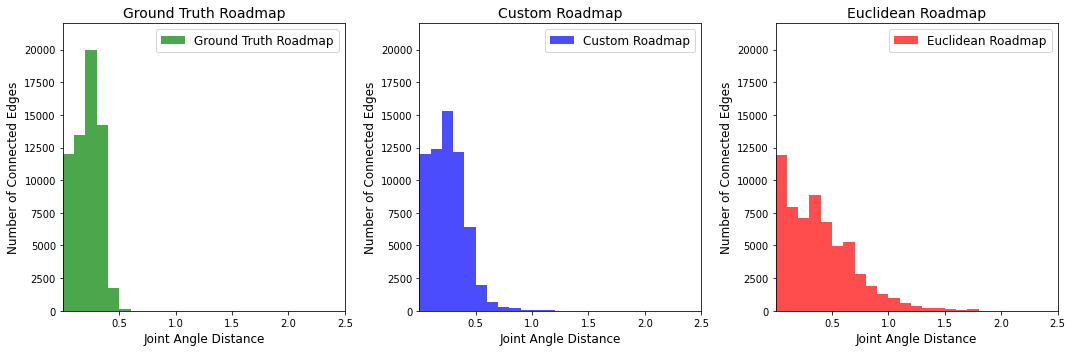

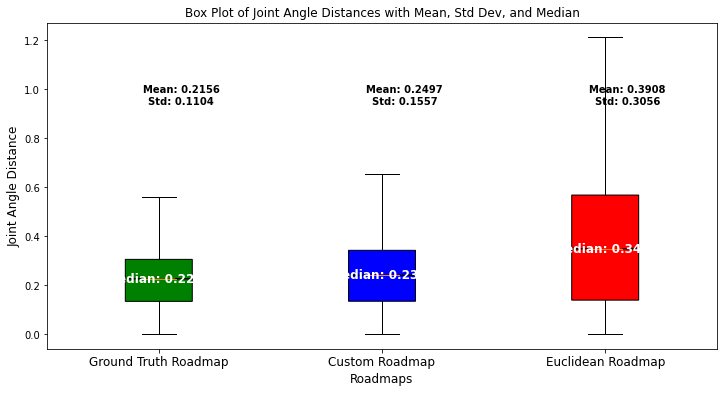

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from itertools import islice

def load_graph(file_path):
    """
    Load a graph object from a pickle file.

    Args:
    - file_path (str): Path to the pickle file.

    Returns:
    - graph: Loaded graph object.
    """
    with open(file_path, 'rb') as f:
        graph = pickle.load(f)
    return graph

# Function to plot joint angles in 3D for a single roadmap
def plot_joint_angles_3d(roadmap, label, output_path):
    joint_angles = [roadmap.nodes[node]['joint_angles'] for node in roadmap.nodes]

    joint_1 = [angles[0] for angles in joint_angles]
    joint_2 = [angles[1] for angles in joint_angles]
    joint_3 = [angles[2] for angles in joint_angles]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the joint angles
    ax.scatter(joint_1, joint_2, joint_3, marker='o', label=label)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title(f'3D Joint Angle Plot for {label}')
    plt.legend()
    plt.savefig(output_path)
    plt.show()
    plt.close()

# Function to plot joint angles in 3D for all roadmaps together
def plot_joint_angles_3d_all(roadmaps, labels, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for roadmap, label in zip(roadmaps, labels):
        joint_angles = [roadmap.nodes[node]['joint_angles'] for node in roadmap.nodes]

        joint_1 = [angles[0] for angles in joint_angles]
        joint_2 = [angles[1] for angles in joint_angles]
        joint_3 = [angles[2] for angles in joint_angles]

        # Plot joint angles for this roadmap
        ax.scatter(joint_1, joint_2, joint_3, marker='o', label=label)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title('3D Joint Angle Plot for All Roadmaps')
    ax.legend()
    plt.savefig(output_path)
    plt.show()
    plt.close()

def plot_connected_joints_3d(roadmap, color, label, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Loop over edges to get the connected nodes
    for edge in roadmap.edges():
        node1, node2 = edge

        joint_angles_1 = roadmap.nodes[node1]['joint_angles']
        joint_angles_2 = roadmap.nodes[node2]['joint_angles']

        joint_1 = [joint_angles_1[0], joint_angles_2[0]]
        joint_2 = [joint_angles_1[1], joint_angles_2[1]]
        joint_3 = [joint_angles_1[2], joint_angles_2[2]]

        # Plot the line between connected nodes (configurations)
        ax.plot(joint_1, joint_2, joint_3, marker='o', color=color)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title(f'Connected Joints 3D Plot for {label}')
    plt.savefig(output_path)
    plt.show()
    plt.close()

# Function to plot connected joints in 3D for all roadmaps together
def plot_connected_joints_3d_all(roadmaps, labels, output_path):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['b', 'g', 'r']  # Different colors for different roadmaps

    for roadmap, label, color in zip(roadmaps, labels, colors):
        # Loop over edges to get the connected nodes
        for edge in roadmap.edges():
            node1, node2 = edge

            joint_angles_1 = roadmap.nodes[node1]['joint_angles']
            joint_angles_2 = roadmap.nodes[node2]['joint_angles']

            joint_1 = [joint_angles_1[0], joint_angles_2[0]]
            joint_2 = [joint_angles_1[1], joint_angles_2[1]]
            joint_3 = [joint_angles_1[2], joint_angles_2[2]]

            # Plot the line between connected nodes (configurations) for this roadmap
            ax.plot(joint_1, joint_2, joint_3, marker='o', label=label if edge == list(roadmap.edges())[0] else "", color=color)

    ax.set_xlabel('Joint 1')
    ax.set_ylabel('Joint 2')
    ax.set_zlabel('Joint 3')

    plt.title('Connected Joints 3D Plot for All Roadmaps')
    ax.legend()
    plt.savefig(output_path)
    plt.show()
    plt.close()

def calculate_joint_angle_distances(graph):
    """
    Calculate joint angle distances for all edges in a graph.

    Args:
    - graph: Graph object containing nodes with joint angle data.

    Returns:
    - distances (list of float): List of joint angle distances between nodes connected by edges.
    """
    distances = []
    for u, v in graph.edges():
        if 'joint_angles' in graph.nodes[u] and 'joint_angles' in graph.nodes[v]:
            joint_angles_u = graph.nodes[u]['joint_angles']
            joint_angles_v = graph.nodes[v]['joint_angles']
            distance = np.linalg.norm(joint_angles_u - joint_angles_v)
            distances.append(distance)

    return distances

def find_common_edges(graph1, graph2):
    """
    Find edges that are common between two graphs.

    Args:
    - graph1: First graph object.
    - graph2: Second graph object.

    Returns:
    - common_edges (set of tuples): Set of edges common to both graphs.
    """
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    common_edges = edges1.intersection(edges2)
    return len(common_edges)

def print_graph_statistics(graph, label):
    """
    Print detailed statistics about the graph for debugging.

    Args:
    - graph: Graph object.
    - label: Label for the graph being analyzed.

    Returns:
    - None
    """
    print(f"\n{label} - Graph Statistics:")
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    
    # Print some sample edges and their weights
    edges_sample = list(islice(graph.edges(data=True), 5))  # Print first 5 edges
    print("Sample edges and weights:")
    for u, v, data in edges_sample:
        print(f"Edge ({u}, {v}) - Weight: {data.get('weight', 'N/A')}")

def plot_joint_distance_histograms(distance_list, labels, colors, output_prefix, fontsize=12):
    """
    Plot histograms of joint angle distances for multiple datasets with same bin width.

    Args:
    - distance_list (list of lists): List of joint angle distances for each dataset.
    - labels (list of str): List of labels for the datasets.
    - output_prefix (str): Prefix for saving the output plot files.
    - fontsize (int): Font size for plot labels and titles.

    Returns:
    - None
    """
    plt.figure(figsize=(15, 5))  # Create a figure for the histograms

    
    # Determine the common range across all datasets (min and max distances)
    min_dist = min(min(distances) for distances in distance_list)
    max_dist = max(max(distances) for distances in distance_list)
    
    
    print(min_dist, max_dist)
    
    # Store bin information for later analysis
    max_bin_info = {}

    # Plot histograms for the datasets
    for i, distances in enumerate(distance_list):
        plt.subplot(1, 3, i + 1)
        
        # Determine the common range across all datasets (min and max distances)
        min_distance = min(distances) 
        max_distance = max(distances)

        # Define a consistent bin width (e.g., 0.1 or any suitable width based on the data)
        bin_width = 0.1  # You can adjust this value based on your needs
        bin_edges = np.arange(min_distance, max_distance, bin_width)   
        
        print("number of bins", len(bin_edges))
        
        counts, bin_edges = np.histogram(distances, bins=bin_edges, range=(min_dist, 2.5))
        
        # Find the bin with the maximum number of data points
        max_bin_index = np.argmax(counts)
        max_bin_count = counts[max_bin_index]
        max_bin_range = (bin_edges[max_bin_index], bin_edges[max_bin_index + 1])

        # Store the max bin information
        max_bin_info[labels[i]] = {
            'max_bin_count': max_bin_count,
            'max_bin_range': max_bin_range
        }
        
        print(max_bin_info)

        # Plot the histogram for the current dataset using the same bin edges
        plt.hist(distances, bins=bin_edges, alpha=0.7, color=colors[i], label=labels[i])
        
        plt.xlim(min_dist, 2.5)
        plt.ylim(0, 22000)

        plt.title(f'{labels[i]}', fontsize=fontsize + 2)
        plt.xlabel('Joint Angle Distance', fontsize=fontsize)
        plt.ylabel('Number of Connected Edges', fontsize=fontsize)
        plt.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(f'{output_prefix}_joint_angle_distances_same_bin_width.png')
    plt.show()
    
def plot_joint_distance_boxplots_with_stats(distance_list, labels, colors, output_path, fontsize=12, showfliers=False):
    """
    Plot box plots of joint angle distances for multiple datasets and display mean, std dev, and median.
    Ensure that annotations are visible even when outliers are not displayed.
    """
    plt.figure(figsize=(12, 6))  # Set the figure size

    # Create the box plot with or without outliers
    box = plt.boxplot(distance_list, patch_artist=True, notch=True, vert=True, showfliers=showfliers)

    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Calculate the overall range of the data (including outliers) for setting the y-axis
    all_data = np.concatenate(distance_list)
    y_upper_limit = max(all_data)*0.9  # Add some margin for annotations
    # y_lower_limit = min(all_data)  # Add margin for the bottom

    # Calculate and display mean, std dev, and median for each dataset
    for i, distances in enumerate(distance_list):
        mean_val = np.mean(distances)
        std_dev_val = np.std(distances)
        median_val = np.median(distances)

        # Adjust position for each annotation based on dataset
        plt.text(i + 1.1, y_upper_limit*.55, f'Mean: {mean_val:.4f}\nStd: {std_dev_val:.4f}', 
                 ha='center', va='top', fontsize=fontsize - 2, color='black', fontweight='bold')

        # Annotate the median value on the box plot
        plt.text(i + 1, median_val, f'Median: {median_val:.4f}', 
                 ha='center', va='center', fontsize=fontsize, color='white', fontweight='bold')

    # Set the y-axis limits manually to ensure visibility of the annotations
    # plt.ylim(y_lower_limit, y_upper_limit)

    # Set labels and title
    plt.xticks(ticks=[1, 2, 3], labels=labels, fontsize=fontsize)
    plt.xlabel('Roadmaps', fontsize=fontsize)
    plt.ylabel('Joint Angle Distance', fontsize=fontsize)
    plt.title('Box Plot of Joint Angle Distances with Mean, Std Dev, and Median', fontsize=fontsize)

    # Save and show the plot
    plt.savefig(output_path)
    plt.show()

def main():
    # Paths to the saved roadmap files
    custom_graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_angle_fresh_432_edges.pkl'
    euclidean_graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_roadmap_angle_fresh_432_edges.pkl'
    joint_space_graph_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_space_roadmap_angle_fresh_432_edges.pkl'

    # Load the roadmaps
    custom_graph = load_graph(custom_graph_path)
    euclidean_graph = load_graph(euclidean_graph_path)
    joint_space_graph = load_graph(joint_space_graph_path)

    # plot_joint_angles_3d(custom_graph, 'Custom Distance', 'custom_roadmap_joint_angles.png')
    # plot_joint_angles_3d(euclidean_graph, 'Euclidean Distance', 'euclidean_roadmap_joint_angles.png')
    # plot_joint_angles_3d(joint_space_graph, 'Ground Truth Distance', 'gt_roadmap_joint_angles.png')

    # # Plot for all roadmaps together
    # roadmaps = [custom_graph, euclidean_graph, joint_space_graph]
    # labels = ['Custom Distance', 'Euclidean Distance', 'Ground Truth Distance']
    # plot_joint_angles_3d_all(roadmaps, labels, 'all_roadmaps_joint_angles.png')

    # plot_connected_joints_3d(custom_graph, 'b', 'Custom Distance', '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/custom_roadmap_n3_joint_angles.png')
    # plot_connected_joints_3d(euclidean_graph, 'r', 'Euclidean Distance', '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/euclidean_roadmap_n3_joint_angles.png')
    # plot_connected_joints_3d(joint_space_graph, 'g', 'Ground Truth Distance', '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/gt_roadmap_n3_joint_angles.png')

    # # Plot for all roadmaps together
    # roadmaps = [custom_graph, euclidean_graph, joint_space_graph]
    # labels = ['Custom Distance', 'Euclidean Distance', 'Ground Truth Distance']
    # plot_connected_joints_3d_all(roadmaps, labels, 'all_roadmaps_joint_angles.png')


    common_edge_custom = find_common_edges(custom_graph, joint_space_graph)
    common_edge_euclidean = find_common_edges(euclidean_graph, joint_space_graph)

    print(common_edge_custom, common_edge_euclidean)

    # Print graph statistics
    print_graph_statistics(custom_graph, "Custom PRM")
    print_graph_statistics(euclidean_graph, "Euclidean PRM")
    print_graph_statistics(joint_space_graph, "Joint Space PRM")

    # Calculate joint angle distances for edges in each roadmap
    custom_joint_distances = calculate_joint_angle_distances(custom_graph)
    euclidean_joint_distances = calculate_joint_angle_distances(euclidean_graph)
    joint_space_joint_distances = calculate_joint_angle_distances(joint_space_graph)
    

    # Ensure that distance lists are not empty
    if len(custom_joint_distances) == 0 or len(euclidean_joint_distances) == 0 or len(joint_space_joint_distances) == 0:
        print("Error: One or more joint angle distance datasets are empty. Please check the input data.")
        return

    # Plot histograms for joint angle distances
    distance_list = [joint_space_joint_distances, custom_joint_distances, euclidean_joint_distances]
    labels = ['Ground Truth Roadmap', 'Custom Roadmap', 'Euclidean Roadmap']
    colors = ['green', 'blue', 'red']
    output_prefix = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/joint_angle_distances'
    plot_joint_distance_histograms(distance_list, labels, colors, output_prefix)
    plot_joint_distance_boxplots_with_stats(distance_list, labels, colors, output_prefix)

if __name__ == "__main__":
    main()


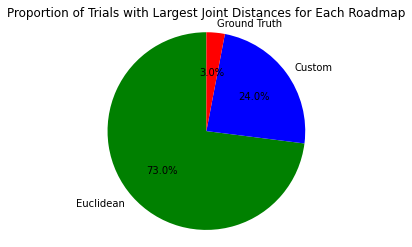

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '/home/jc-merlab/Pictures/Dl_Exps/sim_vs/servoing/configurations_and_goals/gt_fresh_trial/total_joint_angle_distances_fresh.csv'  # Replace with the path to your CSV file
df = pd.read_csv(csv_file_path)

# Create a new column that identifies which roadmap has the largest joint distance for each trial
df['Largest Distance Roadmap'] = df[['Ground Truth', 'Custom', 'Euclidean']].idxmax(axis=1)

# Count the occurrences of each roadmap having the largest joint distance
roadmap_counts = df['Largest Distance Roadmap'].value_counts()

# Plot a pie chart based on the counts
fig, ax = plt.subplots()
ax.pie(roadmap_counts, labels=roadmap_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'blue', 'red'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title for the pie chart
plt.title('Proportion of Trials with Largest Joint Distances for Each Roadmap')

# Show the pie chart
plt.show()